In [18]:
#%load_ext autoreload
#%autoreload 2


import sys
sys.path.append("../../mrf-sim/")
sys.path.append("../../epgpy/")
sys.path.append("../../machines/")
sys.path.append("../../mutools/")
sys.path.append("../../dicomstack/")

#import matplotlib
#matplotlib.use("TkAgg")
from mrfsim import T1MRF
from image_series import *
from utils_mrf import regression_paramMaps_ROI,buildROImask,plot_evolution_params,compare_paramMaps
import json
from finufft import nufft1d1,nufft1d2
from scipy import signal,interpolate
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import matplotlib.pyplot as plt
import numpy as np
from movements import *
from dictoptimizers import *

%matplotlib inline


In [19]:


## Random map simulation

dictfile = "../mrf175_SimReco2.dict"
#dictfile = "mrf175_CS.dict"

with open("../mrf_sequence.json") as f:
    sequence_config = json.load(f)


seq = T1MRF(**sequence_config)

window = 8 #corresponds to nspoke by image
size=(256,256)

file_matlab_paramMap = "../data/SquarePhantom/Phantom1/paramMap.mat"
useGPU=True


In [21]:

###### Building Map
m = MapFromFile("TestPhantomV1",image_size=size,file=file_matlab_paramMap,rounding=False)

m.buildParamMap()





Building Param Map


In [22]:
m.paramMap

{'wT1': array([1586.2674556, 1586.2674556, 1586.2674556, ..., 1846.1561113,
        1846.1561113, 1846.1561113]),
 'wT2': array([80., 80., 80., ..., 80., 80., 80.]),
 'fT1': array([300., 300., 300., ..., 300., 300., 300.]),
 'fT2': array([40., 40., 40., ..., 40., 40., 40.]),
 'attB1': array([0.42893587, 0.42893587, 0.42893587, ..., 0.97988117, 0.97988117,
        0.97988117]),
 'df': array([-0.01166536, -0.01166536, -0.01166536, ...,  0.01842615,
         0.01842615,  0.01842615]),
 'ff': array([0.56186143, 0.56186143, 0.56186143, ..., 0.3545343 , 0.3545343 ,
        0.3545343 ])}

In [31]:
vol_wT1=makevol(m.paramMap["wT1"],m.mask>0)

In [32]:
unique_wT1 = np.unique(vol_wT1)

In [33]:
unique_wT1[1:].shape

(90,)

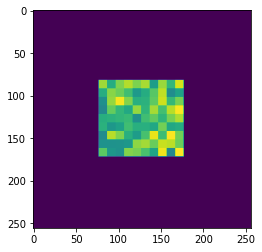

In [29]:
plt.imshow(vol_wT1)

In [38]:
unique_wT1.shape

(90,)

In [41]:
unique_wT1=np.unique(m.paramMap["wT1"])
maskROI = np.zeros(m.paramMap["wT1"].shape)
for i,value in enumerate(unique_wT1):
    maskROI[m.paramMap["wT1"]==value]=i+1

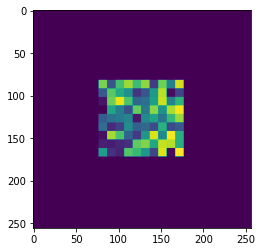

In [43]:
plt.imshow(makevol(maskROI,m.mask>0))

In [34]:
vol_wT1==unique_wT1[1]

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [ ]:
##### Simulating Ref Images
m.build_ref_images(seq,window)

In [4]:
ntimesteps=175
nspoke=8
npoint = 2*m.images_series.shape[1]

radial_traj=Radial(ntimesteps=ntimesteps,nspoke=nspoke,npoint=npoint)
kdata = m.generate_radial_kdata(radial_traj,useGPU=useGPU)

volumes = simulate_radial_undersampled_images(kdata,radial_traj,m.image_size,density_adj=True,useGPU=useGPU)
mask = build_mask_single_image(kdata,radial_traj,m.image_size)

optimizer = SimpleDictSearch(mask=mask,niter=10,seq=seq,trajectory=radial_traj,split=500,pca=True,threshold_pca=15,log=False,useAdjPred=False,useGPU=useGPU)
all_maps_adj=optimizer.search_patterns(dictfile,volumes)


  0%|          | 0/19 [00:00<?, ?it/s]

Water Components Retained 15 out of 175 timesteps
Fat Components Retained 15 out of 175 timesteps
################# ITERATION : Number 0 out of 10 ####################
Calculating optimal fat fraction and best pattern per signal for iteration 0
There are 9000 unique signals to match along 15390 water and 135 fat components
No duplicate signals
PCA transform
0:00:00.014094
Extracting all sig_ws and sig_fs
0:00:00.021707
Calculating alpha optim and flooring
0:00:01.093425
0:00:00.352667
Calculating cost for all signals


 11%|█         | 2/19 [00:02<00:18,  1.07s/it]

0:00:00.900949
Extracting index of pattern with max correl
0:00:00.039554
Filling the lists with results for this loop
0:00:00.000344
PCA transform
0:00:00.018016
Extracting all sig_ws and sig_fs
0:00:00.021446
Calculating alpha optim and flooring
0:00:00.013981
0:00:00.000256
Calculating cost for all signals
0:00:00.023286
Extracting index of pattern with max correl
0:00:00.039966
Filling the lists with results for this loop
0:00:00.000358
PCA transform
0:00:00.014035
Extracting all sig_ws and sig_fs
0:00:00.022006
Calculating alpha optim and flooring


 21%|██        | 4/19 [00:02<00:06,  2.33it/s]

0:00:00.014202
0:00:00.000066
Calculating cost for all signals
0:00:00.024737
Extracting index of pattern with max correl
0:00:00.040250
Filling the lists with results for this loop
0:00:00.000461
PCA transform
0:00:00.014572
Extracting all sig_ws and sig_fs
0:00:00.021723
Calculating alpha optim and flooring
0:00:00.014172
0:00:00.000311
Calculating cost for all signals
0:00:00.023991
Extracting index of pattern with max correl
0:00:00.040361
Filling the lists with results for this loop
0:00:00.000355
PCA transform
0:00:00.014378
Extracting all sig_ws and sig_fs


 26%|██▋       | 5/19 [00:02<00:04,  3.15it/s]

0:00:00.022309
Calculating alpha optim and flooring
0:00:00.014015
0:00:00.000063
Calculating cost for all signals
0:00:00.023865
Extracting index of pattern with max correl
0:00:00.040815
Filling the lists with results for this loop
0:00:00.000364
PCA transform
0:00:00.017191
Extracting all sig_ws and sig_fs
0:00:00.024948
Calculating alpha optim and flooring
0:00:00.014214
0:00:00.000211
Calculating cost for all signals
0:00:00.023881
Extracting index of pattern with max correl


 37%|███▋      | 7/19 [00:03<00:02,  4.82it/s]

0:00:00.042090
Filling the lists with results for this loop
0:00:00.000339
PCA transform
0:00:00.014635
Extracting all sig_ws and sig_fs
0:00:00.022071
Calculating alpha optim and flooring
0:00:00.014567
0:00:00.000222
Calculating cost for all signals
0:00:00.023654
Extracting index of pattern with max correl
0:00:00.040848
Filling the lists with results for this loop
0:00:00.000334
PCA transform
0:00:00.014611
Extracting all sig_ws and sig_fs
0:00:00.022799
Calculating alpha optim and flooring
0:00:00.014255
0:00:00.000225
Calculating cost for all signals
0:00:00.024419
Extracting index of pattern with max correl


 47%|████▋     | 9/19 [00:03<00:01,  6.19it/s]

0:00:00.040679
Filling the lists with results for this loop
0:00:00.000382
PCA transform
0:00:00.015022
Extracting all sig_ws and sig_fs
0:00:00.022867
Calculating alpha optim and flooring
0:00:00.014534
0:00:00.000241
Calculating cost for all signals
0:00:00.024002
Extracting index of pattern with max correl
0:00:00.044513
Filling the lists with results for this loop
0:00:00.000324
PCA transform
0:00:00.014870
Extracting all sig_ws and sig_fs
0:00:00.023512
Calculating alpha optim and flooring
0:00:00.014859
0:00:00.000068
Calculating cost for all signals


 58%|█████▊    | 11/19 [00:03<00:01,  7.17it/s]

0:00:00.025047
Extracting index of pattern with max correl
0:00:00.041369
Filling the lists with results for this loop
0:00:00.000386
PCA transform
0:00:00.014780
Extracting all sig_ws and sig_fs
0:00:00.022819
Calculating alpha optim and flooring
0:00:00.014359
0:00:00.000245
Calculating cost for all signals
0:00:00.023488
Extracting index of pattern with max correl
0:00:00.040587
Filling the lists with results for this loop
0:00:00.000373
PCA transform
0:00:00.014821
Extracting all sig_ws and sig_fs
0:00:00.022328
Calculating alpha optim and flooring


 68%|██████▊   | 13/19 [00:03<00:00,  7.76it/s]

0:00:00.014370
0:00:00.000285
Calculating cost for all signals
0:00:00.023729
Extracting index of pattern with max correl
0:00:00.040325
Filling the lists with results for this loop
0:00:00.000365
PCA transform
0:00:00.014817
Extracting all sig_ws and sig_fs
0:00:00.022668
Calculating alpha optim and flooring
0:00:00.014380
0:00:00.000205
Calculating cost for all signals
0:00:00.025057
Extracting index of pattern with max correl
0:00:00.040743
Filling the lists with results for this loop
0:00:00.000435
PCA transform


 74%|███████▎  | 14/19 [00:03<00:00,  7.91it/s]

0:00:00.015436
Extracting all sig_ws and sig_fs
0:00:00.023083
Calculating alpha optim and flooring
0:00:00.014316
0:00:00.000265
Calculating cost for all signals
0:00:00.024855
Extracting index of pattern with max correl
0:00:00.040888
Filling the lists with results for this loop
0:00:00.000374
PCA transform
0:00:00.014799
Extracting all sig_ws and sig_fs
0:00:00.023247
Calculating alpha optim and flooring
0:00:00.014325
0:00:00.000214
Calculating cost for all signals
0:00:00.024497
Extracting index of pattern with max correl


 84%|████████▍ | 16/19 [00:04<00:00,  8.19it/s]

0:00:00.040765
Filling the lists with results for this loop
0:00:00.000409
PCA transform
0:00:00.014665
Extracting all sig_ws and sig_fs
0:00:00.022773
Calculating alpha optim and flooring
0:00:00.014139
0:00:00.000174
Calculating cost for all signals
0:00:00.023696
Extracting index of pattern with max correl
0:00:00.040195
Filling the lists with results for this loop
0:00:00.000367
PCA transform
0:00:00.014935
Extracting all sig_ws and sig_fs
0:00:00.022574
Calculating alpha optim and flooring
0:00:00.014485
0:00:00.000167
Calculating cost for all signals
0:00:00.023791
Extracting index of pattern with max correl


100%|██████████| 19/19 [00:04<00:00,  4.26it/s]

0:00:00.040853
Filling the lists with results for this loop
0:00:00.000405
PCA transform
0:00:00.014655
Extracting all sig_ws and sig_fs
0:00:00.022330
Calculating alpha optim and flooring
0:00:00.014243
0:00:00.000265
Calculating cost for all signals
0:00:00.029501
Extracting index of pattern with max correl
0:00:00.041497
Filling the lists with results for this loop
0:00:00.000367
PCA transform
0:00:00.009952
Extracting all sig_ws and sig_fs
0:00:00.000062
Calculating alpha optim and flooring
0:00:00.000177
0:00:00.000025
Calculating cost for all signals
0:00:00.000105
Extracting index of pattern with max correl
0:00:00.000013
Filling the lists with results for this loop
0:00:00.000014
Building the maps for iteration 0
Generating prediction volumes and undersampled images for iteration 0
Building Param Map
Building Ref Images
Simulating Water Signal


Simulating Fat Signal
Build dictionary.


  0%|          | 0/19 [00:00<?, ?it/s]

Correcting volumes for iteration 0
################# ITERATION : Number 1 out of 10 ####################
Calculating optimal fat fraction and best pattern per signal for iteration 1
There are 9000 unique signals to match along 15390 water and 135 fat components
No duplicate signals
PCA transform
0:00:00.016941
Extracting all sig_ws and sig_fs
0:00:00.022251
Calculating alpha optim and flooring
0:00:00.013965
0:00:00.000077
Calculating cost for all signals
0:00:00.023906
Extracting index of pattern with max correl


 11%|█         | 2/19 [00:00<00:02,  7.74it/s]

0:00:00.049610
Filling the lists with results for this loop
0:00:00.000697
PCA transform
0:00:00.014217
Extracting all sig_ws and sig_fs
0:00:00.022678
Calculating alpha optim and flooring
0:00:00.013932
0:00:00.000319
Calculating cost for all signals
0:00:00.025349
Extracting index of pattern with max correl
0:00:00.050435
Filling the lists with results for this loop
0:00:00.000326
PCA transform
0:00:00.014721
Extracting all sig_ws and sig_fs
0:00:00.022786
Calculating alpha optim and flooring
0:00:00.013916
0:00:00.000074
Calculating cost for all signals


 21%|██        | 4/19 [00:00<00:01,  7.81it/s]

0:00:00.024071
Extracting index of pattern with max correl
0:00:00.050157
Filling the lists with results for this loop
0:00:00.000344
PCA transform
0:00:00.014349
Extracting all sig_ws and sig_fs
0:00:00.022730
Calculating alpha optim and flooring
0:00:00.014001
0:00:00.000076
Calculating cost for all signals
0:00:00.023516
Extracting index of pattern with max correl
0:00:00.050219
Filling the lists with results for this loop
0:00:00.000257
PCA transform
0:00:00.014521
Extracting all sig_ws and sig_fs


 26%|██▋       | 5/19 [00:00<00:01,  7.76it/s]

0:00:00.023275
Calculating alpha optim and flooring
0:00:00.014106
0:00:00.000076
Calculating cost for all signals
0:00:00.025512
Extracting index of pattern with max correl
0:00:00.050431
Filling the lists with results for this loop
0:00:00.000362
PCA transform
0:00:00.014399
Extracting all sig_ws and sig_fs
0:00:00.023306
Calculating alpha optim and flooring
0:00:00.014019
0:00:00.000074
Calculating cost for all signals
0:00:00.032316
Extracting index of pattern with max correl


 37%|███▋      | 7/19 [00:00<00:01,  7.91it/s]

0:00:00.042954
Filling the lists with results for this loop
0:00:00.000083
PCA transform
0:00:00.013172
Extracting all sig_ws and sig_fs
0:00:00.024716
Calculating alpha optim and flooring
0:00:00.014316
0:00:00.000266
Calculating cost for all signals
0:00:00.024680
Extracting index of pattern with max correl
0:00:00.042307
Filling the lists with results for this loop
0:00:00.000314
PCA transform
0:00:00.012719
Extracting all sig_ws and sig_fs
0:00:00.022062
Calculating alpha optim and flooring
0:00:00.014378
0:00:00.000227
Calculating cost for all signals
0:00:00.023960
Extracting index of pattern with max correl


 47%|████▋     | 9/19 [00:01<00:01,  8.17it/s]

0:00:00.043037
Filling the lists with results for this loop
0:00:00.000360
PCA transform
0:00:00.013197
Extracting all sig_ws and sig_fs
0:00:00.023100
Calculating alpha optim and flooring
0:00:00.014675
0:00:00.000236
Calculating cost for all signals
0:00:00.025471
Extracting index of pattern with max correl
0:00:00.041287
Filling the lists with results for this loop
0:00:00.000368
PCA transform
0:00:00.011970
Extracting all sig_ws and sig_fs
0:00:00.022977
Calculating alpha optim and flooring
0:00:00.014533
0:00:00.000234
Calculating cost for all signals
0:00:00.025547
Extracting index of pattern with max correl


 58%|█████▊    | 11/19 [00:01<00:00,  8.31it/s]

0:00:00.040908
Filling the lists with results for this loop
0:00:00.000088
PCA transform
0:00:00.012296
Extracting all sig_ws and sig_fs
0:00:00.022819
Calculating alpha optim and flooring
0:00:00.014650
0:00:00.000230
Calculating cost for all signals
0:00:00.025430
Extracting index of pattern with max correl
0:00:00.042157
Filling the lists with results for this loop
0:00:00.000305
PCA transform
0:00:00.013155
Extracting all sig_ws and sig_fs
0:00:00.023340
Calculating alpha optim and flooring
0:00:00.014514
0:00:00.000235
Calculating cost for all signals
0:00:00.023950
Extracting index of pattern with max correl


 68%|██████▊   | 13/19 [00:01<00:00,  8.21it/s]

0:00:00.048871
Filling the lists with results for this loop
0:00:00.000366
PCA transform
0:00:00.012813
Extracting all sig_ws and sig_fs
0:00:00.022822
Calculating alpha optim and flooring
0:00:00.014277
0:00:00.000221
Calculating cost for all signals
0:00:00.027415
Extracting index of pattern with max correl
0:00:00.042555
Filling the lists with results for this loop
0:00:00.000342
PCA transform
0:00:00.012154
Extracting all sig_ws and sig_fs
0:00:00.024234
Calculating alpha optim and flooring
0:00:00.015686
0:00:00.000286
Calculating cost for all signals
0:00:00.024427
Extracting index of pattern with max correl


 79%|███████▉  | 15/19 [00:01<00:00,  8.31it/s]

0:00:00.041235
Filling the lists with results for this loop
0:00:00.000095
PCA transform
0:00:00.012590
Extracting all sig_ws and sig_fs
0:00:00.023487
Calculating alpha optim and flooring
0:00:00.014623
0:00:00.000286
Calculating cost for all signals
0:00:00.024206
Extracting index of pattern with max correl
0:00:00.041203
Filling the lists with results for this loop
0:00:00.000118
PCA transform
0:00:00.014883
Extracting all sig_ws and sig_fs
0:00:00.024258
Calculating alpha optim and flooring
0:00:00.014702
0:00:00.000216
Calculating cost for all signals
0:00:00.024358
Extracting index of pattern with max correl


 89%|████████▉ | 17/19 [00:02<00:00,  8.13it/s]

0:00:00.051066
Filling the lists with results for this loop
0:00:00.000290
PCA transform
0:00:00.015601
Extracting all sig_ws and sig_fs
0:00:00.023470
Calculating alpha optim and flooring
0:00:00.014213
0:00:00.000227
Calculating cost for all signals
0:00:00.024460
Extracting index of pattern with max correl
0:00:00.041220
Filling the lists with results for this loop
0:00:00.000361
PCA transform
0:00:00.012114
Extracting all sig_ws and sig_fs
0:00:00.021768
Calculating alpha optim and flooring
0:00:00.014439
0:00:00.000258
Calculating cost for all signals
0:00:00.024453
Extracting index of pattern with max correl


100%|██████████| 19/19 [00:02<00:00,  8.51it/s]


0:00:00.041605
Filling the lists with results for this loop
0:00:00.000393
PCA transform
0:00:00.009023
Extracting all sig_ws and sig_fs
0:00:00.000330
Calculating alpha optim and flooring
0:00:00.000198
0:00:00.000028
Calculating cost for all signals
0:00:00.000107
Extracting index of pattern with max correl
0:00:00.000013
Filling the lists with results for this loop
0:00:00.000016
Building the maps for iteration 1
Generating prediction volumes and undersampled images for iteration 1
Building Param Map
Building Ref Images
Simulating Water Signal
Simulating Fat Signal
Build dictionary.


  0%|          | 0/19 [00:00<?, ?it/s]

Correcting volumes for iteration 1
################# ITERATION : Number 2 out of 10 ####################
Calculating optimal fat fraction and best pattern per signal for iteration 2
There are 9000 unique signals to match along 15390 water and 135 fat components
No duplicate signals
PCA transform
0:00:00.017487
Extracting all sig_ws and sig_fs
0:00:00.023035
Calculating alpha optim and flooring
0:00:00.014317
0:00:00.000063
Calculating cost for all signals
0:00:00.024370
Extracting index of pattern with max correl


 11%|█         | 2/19 [00:00<00:02,  8.19it/s]

0:00:00.046021
Filling the lists with results for this loop
0:00:00.000699
PCA transform
0:00:00.014851
Extracting all sig_ws and sig_fs
0:00:00.022536
Calculating alpha optim and flooring
0:00:00.014035
0:00:00.000455
Calculating cost for all signals
0:00:00.024539
Extracting index of pattern with max correl
0:00:00.040469
Filling the lists with results for this loop
0:00:00.000381
PCA transform
0:00:00.015062
Extracting all sig_ws and sig_fs
0:00:00.022198
Calculating alpha optim and flooring
0:00:00.014086
0:00:00.000267
Calculating cost for all signals
0:00:00.024388
Extracting index of pattern with max correl


 21%|██        | 4/19 [00:00<00:01,  8.39it/s]

0:00:00.041181
Filling the lists with results for this loop
0:00:00.000373
PCA transform
0:00:00.014493
Extracting all sig_ws and sig_fs
0:00:00.021796
Calculating alpha optim and flooring
0:00:00.014042
0:00:00.000065
Calculating cost for all signals
0:00:00.025236
Extracting index of pattern with max correl
0:00:00.039833
Filling the lists with results for this loop
0:00:00.000400
PCA transform
0:00:00.014540
Extracting all sig_ws and sig_fs
0:00:00.022469
Calculating alpha optim and flooring
0:00:00.014009
0:00:00.000064
Calculating cost for all signals
0:00:00.025338
Extracting index of pattern with max correl


 32%|███▏      | 6/19 [00:00<00:01,  8.33it/s]

0:00:00.040194
Filling the lists with results for this loop
0:00:00.000362
PCA transform
0:00:00.014651
Extracting all sig_ws and sig_fs
0:00:00.022005
Calculating alpha optim and flooring
0:00:00.014081
0:00:00.000259
Calculating cost for all signals
0:00:00.023741
Extracting index of pattern with max correl
0:00:00.045519
Filling the lists with results for this loop
0:00:00.000390
PCA transform
0:00:00.015000
Extracting all sig_ws and sig_fs
0:00:00.022330
Calculating alpha optim and flooring
0:00:00.013978
0:00:00.000216
Calculating cost for all signals
0:00:00.023831
Extracting index of pattern with max correl


 42%|████▏     | 8/19 [00:00<00:01,  8.46it/s]

0:00:00.040617
Filling the lists with results for this loop
0:00:00.000434
PCA transform
0:00:00.014717
Extracting all sig_ws and sig_fs
0:00:00.021788
Calculating alpha optim and flooring
0:00:00.013923
0:00:00.000279
Calculating cost for all signals
0:00:00.023871
Extracting index of pattern with max correl
0:00:00.039799
Filling the lists with results for this loop
0:00:00.000349
PCA transform
0:00:00.014770
Extracting all sig_ws and sig_fs
0:00:00.022194
Calculating alpha optim and flooring
0:00:00.014070
0:00:00.000225
Calculating cost for all signals
0:00:00.024241
Extracting index of pattern with max correl


 53%|█████▎    | 10/19 [00:01<00:01,  8.48it/s]

0:00:00.040402
Filling the lists with results for this loop
0:00:00.000354
PCA transform
0:00:00.014696
Extracting all sig_ws and sig_fs
0:00:00.022600
Calculating alpha optim and flooring
0:00:00.014127
0:00:00.000283
Calculating cost for all signals
0:00:00.024038
Extracting index of pattern with max correl
0:00:00.039941
Filling the lists with results for this loop
0:00:00.000359
PCA transform
0:00:00.014740
Extracting all sig_ws and sig_fs
0:00:00.022529
Calculating alpha optim and flooring
0:00:00.013910
0:00:00.000252
Calculating cost for all signals
0:00:00.023581
Extracting index of pattern with max correl


 63%|██████▎   | 12/19 [00:01<00:00,  8.53it/s]

0:00:00.040110
Filling the lists with results for this loop
0:00:00.000113
PCA transform
0:00:00.012696
Extracting all sig_ws and sig_fs
0:00:00.022594
Calculating alpha optim and flooring
0:00:00.013836
0:00:00.000228
Calculating cost for all signals
0:00:00.025020
Extracting index of pattern with max correl
0:00:00.040269
Filling the lists with results for this loop
0:00:00.000386
PCA transform
0:00:00.015130
Extracting all sig_ws and sig_fs
0:00:00.023862
Calculating alpha optim and flooring
0:00:00.014517
0:00:00.000254
Calculating cost for all signals
0:00:00.024397
Extracting index of pattern with max correl


 74%|███████▎  | 14/19 [00:01<00:00,  8.08it/s]

0:00:00.050561
Filling the lists with results for this loop
0:00:00.000424
PCA transform
0:00:00.014205
Extracting all sig_ws and sig_fs
0:00:00.023645
Calculating alpha optim and flooring
0:00:00.014722
0:00:00.000069
Calculating cost for all signals
0:00:00.024903
Extracting index of pattern with max correl
0:00:00.050548
Filling the lists with results for this loop
0:00:00.000387
PCA transform
0:00:00.014910
Extracting all sig_ws and sig_fs
0:00:00.024214
Calculating alpha optim and flooring
0:00:00.014510
0:00:00.000242
Calculating cost for all signals


 84%|████████▍ | 16/19 [00:01<00:00,  7.90it/s]

0:00:00.024294
Extracting index of pattern with max correl
0:00:00.050326
Filling the lists with results for this loop
0:00:00.000352
PCA transform
0:00:00.014018
Extracting all sig_ws and sig_fs
0:00:00.024069
Calculating alpha optim and flooring
0:00:00.014409
0:00:00.000243
Calculating cost for all signals
0:00:00.024328
Extracting index of pattern with max correl
0:00:00.050288
Filling the lists with results for this loop
0:00:00.000365
PCA transform
0:00:00.014788
Extracting all sig_ws and sig_fs


 95%|█████████▍| 18/19 [00:02<00:00,  8.16it/s]

0:00:00.023863
Calculating alpha optim and flooring
0:00:00.014506
0:00:00.000075
Calculating cost for all signals
0:00:00.027840
Extracting index of pattern with max correl
0:00:00.040728
Filling the lists with results for this loop
0:00:00.000340
PCA transform
0:00:00.012190
Extracting all sig_ws and sig_fs
0:00:00.023002
Calculating alpha optim and flooring
0:00:00.013810
0:00:00.000225
Calculating cost for all signals
0:00:00.025044
Extracting index of pattern with max correl
0:00:00.039353
Filling the lists with results for this loop
0:00:00.000304
PCA transform


100%|██████████| 19/19 [00:02<00:00,  8.66it/s]


0:00:00.009096
Extracting all sig_ws and sig_fs
0:00:00.000477
Calculating alpha optim and flooring
0:00:00.000224
0:00:00.000032
Calculating cost for all signals
0:00:00.000159
Extracting index of pattern with max correl
0:00:00.000016
Filling the lists with results for this loop
0:00:00.000019
Building the maps for iteration 2
Generating prediction volumes and undersampled images for iteration 2
Building Param Map
Building Ref Images
Simulating Water Signal
Simulating Fat Signal
Build dictionary.


  0%|          | 0/19 [00:00<?, ?it/s]

Correcting volumes for iteration 2
################# ITERATION : Number 3 out of 10 ####################
Calculating optimal fat fraction and best pattern per signal for iteration 3
There are 9000 unique signals to match along 15390 water and 135 fat components
No duplicate signals
PCA transform
0:00:00.014667
Extracting all sig_ws and sig_fs
0:00:00.023585
Calculating alpha optim and flooring
0:00:00.013955
0:00:00.000373
Calculating cost for all signals
0:00:00.024247
Extracting index of pattern with max correl


 11%|█         | 2/19 [00:00<00:02,  7.75it/s]

0:00:00.050695
Filling the lists with results for this loop
0:00:00.000396
PCA transform
0:00:00.014952
Extracting all sig_ws and sig_fs
0:00:00.023971
Calculating alpha optim and flooring
0:00:00.014453
0:00:00.000074
Calculating cost for all signals
0:00:00.025535
Extracting index of pattern with max correl
0:00:00.048128
Filling the lists with results for this loop
0:00:00.000405
PCA transform
0:00:00.012595
Extracting all sig_ws and sig_fs
0:00:00.022294
Calculating alpha optim and flooring
0:00:00.013919
0:00:00.000217
Calculating cost for all signals


 21%|██        | 4/19 [00:00<00:01,  8.12it/s]

0:00:00.023414
Extracting index of pattern with max correl
0:00:00.039772
Filling the lists with results for this loop
0:00:00.000317
PCA transform
0:00:00.012331
Extracting all sig_ws and sig_fs
0:00:00.022652
Calculating alpha optim and flooring
0:00:00.013961
0:00:00.000294
Calculating cost for all signals
0:00:00.023745
Extracting index of pattern with max correl
0:00:00.049984
Filling the lists with results for this loop
0:00:00.000363
PCA transform
0:00:00.014574
Extracting all sig_ws and sig_fs


 26%|██▋       | 5/19 [00:00<00:01,  8.00it/s]

0:00:00.023372
Calculating alpha optim and flooring
0:00:00.013973
0:00:00.000155
Calculating cost for all signals
0:00:00.024904
Extracting index of pattern with max correl
0:00:00.049864
Filling the lists with results for this loop
0:00:00.000354
PCA transform
0:00:00.014822
Extracting all sig_ws and sig_fs
0:00:00.023792
Calculating alpha optim and flooring
0:00:00.014344
0:00:00.000258
Calculating cost for all signals
0:00:00.025135
Extracting index of pattern with max correl


 37%|███▋      | 7/19 [00:00<00:01,  7.86it/s]

0:00:00.049950
Filling the lists with results for this loop
0:00:00.000379
PCA transform
0:00:00.014743
Extracting all sig_ws and sig_fs
0:00:00.023878
Calculating alpha optim and flooring
0:00:00.013844
0:00:00.000202
Calculating cost for all signals
0:00:00.023619
Extracting index of pattern with max correl
0:00:00.049884
Filling the lists with results for this loop
0:00:00.000382
PCA transform
0:00:00.014990
Extracting all sig_ws and sig_fs
0:00:00.023047
Calculating alpha optim and flooring
0:00:00.014132
0:00:00.000234
Calculating cost for all signals


 47%|████▋     | 9/19 [00:01<00:01,  8.23it/s]

0:00:00.024534
Extracting index of pattern with max correl
0:00:00.042152
Filling the lists with results for this loop
0:00:00.000078
PCA transform
0:00:00.011702
Extracting all sig_ws and sig_fs
0:00:00.021697
Calculating alpha optim and flooring
0:00:00.013888
0:00:00.000236
Calculating cost for all signals
0:00:00.024595
Extracting index of pattern with max correl
0:00:00.039814
Filling the lists with results for this loop
0:00:00.000331
PCA transform
0:00:00.011689
Extracting all sig_ws and sig_fs
0:00:00.022134
Calculating alpha optim and flooring


 58%|█████▊    | 11/19 [00:01<00:00,  8.20it/s]

0:00:00.013846
0:00:00.000239
Calculating cost for all signals
0:00:00.025012
Extracting index of pattern with max correl
0:00:00.039730
Filling the lists with results for this loop
0:00:00.000325
PCA transform
0:00:00.012763
Extracting all sig_ws and sig_fs
0:00:00.022879
Calculating alpha optim and flooring
0:00:00.013859
0:00:00.000326
Calculating cost for all signals
0:00:00.025832
Extracting index of pattern with max correl
0:00:00.050889
Filling the lists with results for this loop
0:00:00.000140
PCA transform


 63%|██████▎   | 12/19 [00:01<00:00,  8.03it/s]

0:00:00.015358
Extracting all sig_ws and sig_fs
0:00:00.023951
Calculating alpha optim and flooring
0:00:00.014542
0:00:00.000232
Calculating cost for all signals
0:00:00.024024
Extracting index of pattern with max correl
0:00:00.050979
Filling the lists with results for this loop
0:00:00.000380
PCA transform
0:00:00.015061
Extracting all sig_ws and sig_fs
0:00:00.024212
Calculating alpha optim and flooring
0:00:00.014351
0:00:00.000204
Calculating cost for all signals
0:00:00.024351
Extracting index of pattern with max correl


 74%|███████▎  | 14/19 [00:01<00:00,  8.04it/s]

0:00:00.050889
Filling the lists with results for this loop
0:00:00.000398
PCA transform
0:00:00.014939
Extracting all sig_ws and sig_fs
0:00:00.024296
Calculating alpha optim and flooring
0:00:00.014218
0:00:00.000237
Calculating cost for all signals
0:00:00.024173
Extracting index of pattern with max correl
0:00:00.040002
Filling the lists with results for this loop
0:00:00.000346
PCA transform
0:00:00.013176
Extracting all sig_ws and sig_fs
0:00:00.023031
Calculating alpha optim and flooring
0:00:00.014205
0:00:00.000209
Calculating cost for all signals
0:00:00.023583
Extracting index of pattern with max correl


 84%|████████▍ | 16/19 [00:01<00:00,  7.91it/s]

0:00:00.050052
Filling the lists with results for this loop
0:00:00.000409
PCA transform
0:00:00.014740
Extracting all sig_ws and sig_fs
0:00:00.023382
Calculating alpha optim and flooring
0:00:00.014155
0:00:00.000249
Calculating cost for all signals
0:00:00.025732
Extracting index of pattern with max correl
0:00:00.049770
Filling the lists with results for this loop
0:00:00.000366
PCA transform
0:00:00.014710
Extracting all sig_ws and sig_fs
0:00:00.022706
Calculating alpha optim and flooring
0:00:00.013971
0:00:00.000069
Calculating cost for all signals


100%|██████████| 19/19 [00:02<00:00,  8.37it/s]

0:00:00.023993
Extracting index of pattern with max correl
0:00:00.051023
Filling the lists with results for this loop
0:00:00.000357
PCA transform
0:00:00.014761
Extracting all sig_ws and sig_fs
0:00:00.023840
Calculating alpha optim and flooring
0:00:00.014393
0:00:00.000216
Calculating cost for all signals
0:00:00.024604
Extracting index of pattern with max correl
0:00:00.050671
Filling the lists with results for this loop
0:00:00.000355
PCA transform
0:00:00.010002
Extracting all sig_ws and sig_fs
0:00:00.000365
Calculating alpha optim and flooring
0:00:00.000381
0:00:00.000060
Calculating cost for all signals
0:00:00.000373
Extracting index of pattern with max correl
0:00:00.000026
Filling the lists with results for this loop
0:00:00.000033
Building the maps for iteration 3


Generating prediction volumes and undersampled images for iteration 3
Building Param Map
Building Ref Images
Simulating Water Signal
Simulating Fat Signal
Build dictionary.


  0%|          | 0/19 [00:00<?, ?it/s]

Correcting volumes for iteration 3
################# ITERATION : Number 4 out of 10 ####################
Calculating optimal fat fraction and best pattern per signal for iteration 4
There are 9000 unique signals to match along 15390 water and 135 fat components
No duplicate signals
PCA transform
0:00:00.017409
Extracting all sig_ws and sig_fs
0:00:00.021365
Calculating alpha optim and flooring
0:00:00.013763
0:00:00.000246
Calculating cost for all signals
0:00:00.025214
Extracting index of pattern with max correl


 11%|█         | 2/19 [00:00<00:02,  8.48it/s]

0:00:00.039586
Filling the lists with results for this loop
0:00:00.000307
PCA transform
0:00:00.013082
Extracting all sig_ws and sig_fs
0:00:00.022973
Calculating alpha optim and flooring
0:00:00.013809
0:00:00.000263
Calculating cost for all signals
0:00:00.025693
Extracting index of pattern with max correl
0:00:00.040275
Filling the lists with results for this loop
0:00:00.000345
PCA transform
0:00:00.012905
Extracting all sig_ws and sig_fs
0:00:00.022727
Calculating alpha optim and flooring
0:00:00.013827
0:00:00.000210
Calculating cost for all signals
0:00:00.024297
Extracting index of pattern with max correl


 21%|██        | 4/19 [00:00<00:01,  8.62it/s]

0:00:00.040514
Filling the lists with results for this loop
0:00:00.000405
PCA transform
0:00:00.012272
Extracting all sig_ws and sig_fs
0:00:00.022334
Calculating alpha optim and flooring
0:00:00.013769
0:00:00.000186
Calculating cost for all signals
0:00:00.023622
Extracting index of pattern with max correl
0:00:00.040599
Filling the lists with results for this loop
0:00:00.000123
PCA transform
0:00:00.012029
Extracting all sig_ws and sig_fs
0:00:00.021989
Calculating alpha optim and flooring
0:00:00.013750
0:00:00.000167
Calculating cost for all signals
0:00:00.023936
Extracting index of pattern with max correl


 32%|███▏      | 6/19 [00:00<00:01,  8.73it/s]

0:00:00.040028
Filling the lists with results for this loop
0:00:00.000408
PCA transform
0:00:00.011698
Extracting all sig_ws and sig_fs
0:00:00.021713
Calculating alpha optim and flooring
0:00:00.013944
0:00:00.000225
Calculating cost for all signals
0:00:00.024375
Extracting index of pattern with max correl
0:00:00.040129
Filling the lists with results for this loop
0:00:00.000332
PCA transform
0:00:00.012224
Extracting all sig_ws and sig_fs
0:00:00.021721
Calculating alpha optim and flooring
0:00:00.013933
0:00:00.000059
Calculating cost for all signals
0:00:00.024271
Extracting index of pattern with max correl


 42%|████▏     | 8/19 [00:00<00:01,  8.75it/s]

0:00:00.039702
Filling the lists with results for this loop
0:00:00.000398
PCA transform
0:00:00.011746
Extracting all sig_ws and sig_fs
0:00:00.022822
Calculating alpha optim and flooring
0:00:00.013813
0:00:00.000186
Calculating cost for all signals
0:00:00.024242
Extracting index of pattern with max correl
0:00:00.039753
Filling the lists with results for this loop
0:00:00.000286
PCA transform
0:00:00.012835
Extracting all sig_ws and sig_fs
0:00:00.022355
Calculating alpha optim and flooring
0:00:00.013911
0:00:00.000167
Calculating cost for all signals
0:00:00.023787
Extracting index of pattern with max correl


 53%|█████▎    | 10/19 [00:01<00:01,  8.76it/s]

0:00:00.040645
Filling the lists with results for this loop
0:00:00.000077
PCA transform
0:00:00.011965
Extracting all sig_ws and sig_fs
0:00:00.022390
Calculating alpha optim and flooring
0:00:00.013758
0:00:00.000206
Calculating cost for all signals
0:00:00.023612
Extracting index of pattern with max correl
0:00:00.039996
Filling the lists with results for this loop
0:00:00.000076
PCA transform
0:00:00.012827
Extracting all sig_ws and sig_fs
0:00:00.022023
Calculating alpha optim and flooring
0:00:00.013798
0:00:00.000185
Calculating cost for all signals
0:00:00.023913
Extracting index of pattern with max correl


 63%|██████▎   | 12/19 [00:01<00:00,  8.77it/s]

0:00:00.040369
Filling the lists with results for this loop
0:00:00.000183
PCA transform
0:00:00.012215
Extracting all sig_ws and sig_fs
0:00:00.022330
Calculating alpha optim and flooring
0:00:00.013793
0:00:00.000227
Calculating cost for all signals
0:00:00.023608
Extracting index of pattern with max correl
0:00:00.039526
Filling the lists with results for this loop
0:00:00.000074
PCA transform
0:00:00.011834
Extracting all sig_ws and sig_fs
0:00:00.021409
Calculating alpha optim and flooring
0:00:00.013949
0:00:00.000241
Calculating cost for all signals
0:00:00.023548
Extracting index of pattern with max correl


 74%|███████▎  | 14/19 [00:01<00:00,  8.69it/s]

0:00:00.043226
Filling the lists with results for this loop
0:00:00.000189
PCA transform
0:00:00.011560
Extracting all sig_ws and sig_fs
0:00:00.022553
Calculating alpha optim and flooring
0:00:00.013807
0:00:00.000208
Calculating cost for all signals
0:00:00.024979
Extracting index of pattern with max correl
0:00:00.041497
Filling the lists with results for this loop
0:00:00.000338
PCA transform
0:00:00.012565
Extracting all sig_ws and sig_fs
0:00:00.022027
Calculating alpha optim and flooring
0:00:00.013965
0:00:00.000211
Calculating cost for all signals
0:00:00.024945
Extracting index of pattern with max correl


 84%|████████▍ | 16/19 [00:01<00:00,  8.64it/s]

0:00:00.039875
Filling the lists with results for this loop
0:00:00.000382
PCA transform
0:00:00.011983
Extracting all sig_ws and sig_fs
0:00:00.022619
Calculating alpha optim and flooring
0:00:00.014966
0:00:00.000266
Calculating cost for all signals
0:00:00.024111
Extracting index of pattern with max correl
0:00:00.041886
Filling the lists with results for this loop
0:00:00.000364
PCA transform
0:00:00.013240
Extracting all sig_ws and sig_fs
0:00:00.021848
Calculating alpha optim and flooring
0:00:00.014001
0:00:00.000061
Calculating cost for all signals
0:00:00.023724
Extracting index of pattern with max correl


100%|██████████| 19/19 [00:02<00:00,  9.13it/s]

0:00:00.040061
Filling the lists with results for this loop
0:00:00.000075
PCA transform
0:00:00.012344
Extracting all sig_ws and sig_fs
0:00:00.022398
Calculating alpha optim and flooring
0:00:00.013809
0:00:00.000059
Calculating cost for all signals
0:00:00.023672
Extracting index of pattern with max correl
0:00:00.040011
Filling the lists with results for this loop
0:00:00.000075
PCA transform
0:00:00.009421
Extracting all sig_ws and sig_fs
0:00:00.000159
Calculating alpha optim and flooring
0:00:00.000209
0:00:00.000029
Calculating cost for all signals
0:00:00.000115
Extracting index of pattern with max correl
0:00:00.000013
Filling the lists with results for this loop
0:00:00.000014
Building the maps for iteration 4
Generating prediction volumes and undersampled images for iteration 4
Building Param Map
Building Ref Images
Simulating Water Signal


Simulating Fat Signal
Build dictionary.


  0%|          | 0/19 [00:00<?, ?it/s]

Correcting volumes for iteration 4
################# ITERATION : Number 5 out of 10 ####################
Calculating optimal fat fraction and best pattern per signal for iteration 5
There are 9000 unique signals to match along 15390 water and 135 fat components
No duplicate signals
PCA transform
0:00:00.017912
Extracting all sig_ws and sig_fs
0:00:00.022331
Calculating alpha optim and flooring
0:00:00.014040
0:00:00.000079
Calculating cost for all signals
0:00:00.024329
Extracting index of pattern with max correl


 11%|█         | 2/19 [00:00<00:02,  7.79it/s]

0:00:00.049995
Filling the lists with results for this loop
0:00:00.000371
PCA transform
0:00:00.014200
Extracting all sig_ws and sig_fs
0:00:00.023075
Calculating alpha optim and flooring
0:00:00.014068
0:00:00.000421
Calculating cost for all signals
0:00:00.024369
Extracting index of pattern with max correl
0:00:00.050000
Filling the lists with results for this loop
0:00:00.000259
PCA transform
0:00:00.014811
Extracting all sig_ws and sig_fs
0:00:00.022973
Calculating alpha optim and flooring
0:00:00.014094
0:00:00.000073
Calculating cost for all signals


 21%|██        | 4/19 [00:00<00:01,  8.05it/s]

0:00:00.024156
Extracting index of pattern with max correl
0:00:00.050412
Filling the lists with results for this loop
0:00:00.000441
PCA transform
0:00:00.014777
Extracting all sig_ws and sig_fs
0:00:00.022969
Calculating alpha optim and flooring
0:00:00.013868
0:00:00.000060
Calculating cost for all signals
0:00:00.024370
Extracting index of pattern with max correl
0:00:00.039577
Filling the lists with results for this loop
0:00:00.000447
PCA transform
0:00:00.013666
Extracting all sig_ws and sig_fs


 32%|███▏      | 6/19 [00:00<00:01,  8.39it/s]

0:00:00.021185
Calculating alpha optim and flooring
0:00:00.013897
0:00:00.000255
Calculating cost for all signals
0:00:00.024577
Extracting index of pattern with max correl
0:00:00.039644
Filling the lists with results for this loop
0:00:00.000319
PCA transform
0:00:00.014150
Extracting all sig_ws and sig_fs
0:00:00.022189
Calculating alpha optim and flooring
0:00:00.013840
0:00:00.000225
Calculating cost for all signals
0:00:00.024117
Extracting index of pattern with max correl
0:00:00.039514
Filling the lists with results for this loop
0:00:00.000319
PCA transform


 37%|███▋      | 7/19 [00:00<00:01,  8.40it/s]

0:00:00.012452
Extracting all sig_ws and sig_fs
0:00:00.021806
Calculating alpha optim and flooring
0:00:00.013768
0:00:00.000231
Calculating cost for all signals
0:00:00.024188
Extracting index of pattern with max correl
0:00:00.045062
Filling the lists with results for this loop
0:00:00.000350
PCA transform
0:00:00.014294
Extracting all sig_ws and sig_fs
0:00:00.027200
Calculating alpha optim and flooring
0:00:00.015540
0:00:00.000229
Calculating cost for all signals
0:00:00.027376
Extracting index of pattern with max correl


 47%|████▋     | 9/19 [00:01<00:01,  8.25it/s]

0:00:00.050206
Filling the lists with results for this loop
0:00:00.000188
PCA transform
0:00:00.011763
Extracting all sig_ws and sig_fs
0:00:00.021780
Calculating alpha optim and flooring
0:00:00.013873
0:00:00.000243
Calculating cost for all signals
0:00:00.023450
Extracting index of pattern with max correl
0:00:00.040837
Filling the lists with results for this loop
0:00:00.000338
PCA transform
0:00:00.011639
Extracting all sig_ws and sig_fs
0:00:00.021457
Calculating alpha optim and flooring
0:00:00.014139
0:00:00.000337
Calculating cost for all signals
0:00:00.023558
Extracting index of pattern with max correl


 58%|█████▊    | 11/19 [00:01<00:00,  8.49it/s]

0:00:00.040507
Filling the lists with results for this loop
0:00:00.000190
PCA transform
0:00:00.011909
Extracting all sig_ws and sig_fs
0:00:00.022844
Calculating alpha optim and flooring
0:00:00.013823
0:00:00.000267
Calculating cost for all signals
0:00:00.024215
Extracting index of pattern with max correl
0:00:00.040430
Filling the lists with results for this loop
0:00:00.000377
PCA transform
0:00:00.013010
Extracting all sig_ws and sig_fs
0:00:00.022085
Calculating alpha optim and flooring
0:00:00.013837
0:00:00.000242
Calculating cost for all signals
0:00:00.025025
Extracting index of pattern with max correl


 68%|██████▊   | 13/19 [00:01<00:00,  8.56it/s]

0:00:00.040459
Filling the lists with results for this loop
0:00:00.000394
PCA transform
0:00:00.012086
Extracting all sig_ws and sig_fs
0:00:00.022241
Calculating alpha optim and flooring
0:00:00.014062
0:00:00.000256
Calculating cost for all signals
0:00:00.023676
Extracting index of pattern with max correl
0:00:00.041822
Filling the lists with results for this loop
0:00:00.000382
PCA transform
0:00:00.012350
Extracting all sig_ws and sig_fs
0:00:00.021931
Calculating alpha optim and flooring
0:00:00.013921
0:00:00.000229
Calculating cost for all signals
0:00:00.023951
Extracting index of pattern with max correl


 79%|███████▉  | 15/19 [00:01<00:00,  8.62it/s]

0:00:00.040110
Filling the lists with results for this loop
0:00:00.000406
PCA transform
0:00:00.012619
Extracting all sig_ws and sig_fs
0:00:00.022222
Calculating alpha optim and flooring
0:00:00.013937
0:00:00.000252
Calculating cost for all signals
0:00:00.024302
Extracting index of pattern with max correl
0:00:00.040777
Filling the lists with results for this loop
0:00:00.000339
PCA transform
0:00:00.012807
Extracting all sig_ws and sig_fs
0:00:00.022013
Calculating alpha optim and flooring
0:00:00.014154
0:00:00.000214
Calculating cost for all signals
0:00:00.024544
Extracting index of pattern with max correl


 89%|████████▉ | 17/19 [00:02<00:00,  8.62it/s]

0:00:00.040151
Filling the lists with results for this loop
0:00:00.000406
PCA transform
0:00:00.012817
Extracting all sig_ws and sig_fs
0:00:00.022490
Calculating alpha optim and flooring
0:00:00.013944
0:00:00.000246
Calculating cost for all signals
0:00:00.024861
Extracting index of pattern with max correl
0:00:00.040123
Filling the lists with results for this loop
0:00:00.000327
PCA transform
0:00:00.012885
Extracting all sig_ws and sig_fs
0:00:00.022145
Calculating alpha optim and flooring
0:00:00.014165
0:00:00.000198
Calculating cost for all signals
0:00:00.025243
Extracting index of pattern with max correl


100%|██████████| 19/19 [00:02<00:00,  8.82it/s]


0:00:00.041060
Filling the lists with results for this loop
0:00:00.000074
PCA transform
0:00:00.009383
Extracting all sig_ws and sig_fs
0:00:00.000341
Calculating alpha optim and flooring
0:00:00.000194
0:00:00.000026
Calculating cost for all signals
0:00:00.000105
Extracting index of pattern with max correl
0:00:00.000010
Filling the lists with results for this loop
0:00:00.000015
Building the maps for iteration 5
Generating prediction volumes and undersampled images for iteration 5
Building Param Map
Building Ref Images
Simulating Water Signal
Simulating Fat Signal
Build dictionary.


  0%|          | 0/19 [00:00<?, ?it/s]

Correcting volumes for iteration 5
################# ITERATION : Number 6 out of 10 ####################
Calculating optimal fat fraction and best pattern per signal for iteration 6
There are 9000 unique signals to match along 15390 water and 135 fat components
No duplicate signals
PCA transform
0:00:00.022413
Extracting all sig_ws and sig_fs
0:00:00.024045
Calculating alpha optim and flooring
0:00:00.013987
0:00:00.000074
Calculating cost for all signals
0:00:00.026158
Extracting index of pattern with max correl


 11%|█         | 2/19 [00:00<00:02,  7.51it/s]

0:00:00.050112
Filling the lists with results for this loop
0:00:00.000399
PCA transform
0:00:00.014562
Extracting all sig_ws and sig_fs
0:00:00.023640
Calculating alpha optim and flooring
0:00:00.014071
0:00:00.000072
Calculating cost for all signals
0:00:00.025118
Extracting index of pattern with max correl
0:00:00.050198
Filling the lists with results for this loop
0:00:00.000411
PCA transform
0:00:00.014656
Extracting all sig_ws and sig_fs
0:00:00.023422
Calculating alpha optim and flooring
0:00:00.014093
0:00:00.000075
Calculating cost for all signals


 21%|██        | 4/19 [00:00<00:01,  7.65it/s]

0:00:00.025085
Extracting index of pattern with max correl
0:00:00.050247
Filling the lists with results for this loop
0:00:00.000403
PCA transform
0:00:00.014700
Extracting all sig_ws and sig_fs
0:00:00.023319
Calculating alpha optim and flooring
0:00:00.014029
0:00:00.000205
Calculating cost for all signals
0:00:00.024328
Extracting index of pattern with max correl
0:00:00.050043
Filling the lists with results for this loop
0:00:00.000374
PCA transform
0:00:00.014582
Extracting all sig_ws and sig_fs


 26%|██▋       | 5/19 [00:00<00:01,  7.71it/s]

0:00:00.023237
Calculating alpha optim and flooring
0:00:00.014302
0:00:00.000079
Calculating cost for all signals
0:00:00.031547
Extracting index of pattern with max correl
0:00:00.042123
Filling the lists with results for this loop
0:00:00.000339
PCA transform
0:00:00.012947
Extracting all sig_ws and sig_fs
0:00:00.022665
Calculating alpha optim and flooring
0:00:00.014093
0:00:00.000224
Calculating cost for all signals
0:00:00.023829
Extracting index of pattern with max correl


 37%|███▋      | 7/19 [00:00<00:01,  8.20it/s]

0:00:00.041704
Filling the lists with results for this loop
0:00:00.000340
PCA transform
0:00:00.012084
Extracting all sig_ws and sig_fs
0:00:00.022039
Calculating alpha optim and flooring
0:00:00.014120
0:00:00.000225
Calculating cost for all signals
0:00:00.024443
Extracting index of pattern with max correl
0:00:00.041028
Filling the lists with results for this loop
0:00:00.000304
PCA transform
0:00:00.011782
Extracting all sig_ws and sig_fs
0:00:00.021596
Calculating alpha optim and flooring
0:00:00.014090
0:00:00.000214
Calculating cost for all signals
0:00:00.023960
Extracting index of pattern with max correl


 47%|████▋     | 9/19 [00:01<00:01,  8.48it/s]

0:00:00.040207
Filling the lists with results for this loop
0:00:00.000399
PCA transform
0:00:00.012231
Extracting all sig_ws and sig_fs
0:00:00.022623
Calculating alpha optim and flooring
0:00:00.013936
0:00:00.000182
Calculating cost for all signals
0:00:00.023997
Extracting index of pattern with max correl
0:00:00.040903
Filling the lists with results for this loop
0:00:00.000343
PCA transform
0:00:00.013296
Extracting all sig_ws and sig_fs
0:00:00.021937
Calculating alpha optim and flooring
0:00:00.014105
0:00:00.000229
Calculating cost for all signals
0:00:00.023840
Extracting index of pattern with max correl


 58%|█████▊    | 11/19 [00:01<00:00,  8.59it/s]

0:00:00.039972
Filling the lists with results for this loop
0:00:00.000360
PCA transform
0:00:00.011816
Extracting all sig_ws and sig_fs
0:00:00.022128
Calculating alpha optim and flooring
0:00:00.013808
0:00:00.000223
Calculating cost for all signals
0:00:00.025668
Extracting index of pattern with max correl
0:00:00.039699
Filling the lists with results for this loop
0:00:00.000332
PCA transform
0:00:00.012295
Extracting all sig_ws and sig_fs
0:00:00.022869
Calculating alpha optim and flooring
0:00:00.014062
0:00:00.000249
Calculating cost for all signals
0:00:00.028418
Extracting index of pattern with max correl


 68%|██████▊   | 13/19 [00:01<00:00,  8.35it/s]

0:00:00.053713
Filling the lists with results for this loop
0:00:00.000401
PCA transform
0:00:00.013427
Extracting all sig_ws and sig_fs
0:00:00.022210
Calculating alpha optim and flooring
0:00:00.013970
0:00:00.000259
Calculating cost for all signals
0:00:00.024015
Extracting index of pattern with max correl
0:00:00.040481
Filling the lists with results for this loop
0:00:00.000414
PCA transform
0:00:00.013061
Extracting all sig_ws and sig_fs
0:00:00.023733
Calculating alpha optim and flooring
0:00:00.013852
0:00:00.000173
Calculating cost for all signals
0:00:00.023926
Extracting index of pattern with max correl


 79%|███████▉  | 15/19 [00:01<00:00,  8.51it/s]

0:00:00.040902
Filling the lists with results for this loop
0:00:00.000410
PCA transform
0:00:00.012510
Extracting all sig_ws and sig_fs
0:00:00.021888
Calculating alpha optim and flooring
0:00:00.014041
0:00:00.000220
Calculating cost for all signals
0:00:00.023913
Extracting index of pattern with max correl
0:00:00.040139
Filling the lists with results for this loop
0:00:00.000081
PCA transform
0:00:00.011785
Extracting all sig_ws and sig_fs
0:00:00.022232
Calculating alpha optim and flooring
0:00:00.013933
0:00:00.000178
Calculating cost for all signals
0:00:00.024357
Extracting index of pattern with max correl


 89%|████████▉ | 17/19 [00:02<00:00,  8.35it/s]

0:00:00.040178
Filling the lists with results for this loop
0:00:00.000390
PCA transform
0:00:00.012334
Extracting all sig_ws and sig_fs
0:00:00.022008
Calculating alpha optim and flooring
0:00:00.014285
0:00:00.000342
Calculating cost for all signals
0:00:00.025256
Extracting index of pattern with max correl
0:00:00.051196
Filling the lists with results for this loop
0:00:00.000367
PCA transform
0:00:00.014097
Extracting all sig_ws and sig_fs
0:00:00.024465
Calculating alpha optim and flooring
0:00:00.014807
0:00:00.000262
Calculating cost for all signals


100%|██████████| 19/19 [00:02<00:00,  8.59it/s]


0:00:00.024630
Extracting index of pattern with max correl
0:00:00.051180
Filling the lists with results for this loop
0:00:00.000348
PCA transform
0:00:00.010323
Extracting all sig_ws and sig_fs
0:00:00.000325
Calculating alpha optim and flooring
0:00:00.000231
0:00:00.000032
Calculating cost for all signals
0:00:00.000133
Extracting index of pattern with max correl
0:00:00.000016
Filling the lists with results for this loop
0:00:00.000018
Building the maps for iteration 6
Generating prediction volumes and undersampled images for iteration 6
Building Param Map
Building Ref Images
Simulating Water Signal
Simulating Fat Signal
Build dictionary.


  0%|          | 0/19 [00:00<?, ?it/s]

Correcting volumes for iteration 6
################# ITERATION : Number 7 out of 10 ####################
Calculating optimal fat fraction and best pattern per signal for iteration 7
There are 9000 unique signals to match along 15390 water and 135 fat components
No duplicate signals
PCA transform
0:00:00.017197
Extracting all sig_ws and sig_fs
0:00:00.022183
Calculating alpha optim and flooring
0:00:00.013780
0:00:00.000065
Calculating cost for all signals
0:00:00.025369
Extracting index of pattern with max correl


 11%|█         | 2/19 [00:00<00:02,  7.88it/s]

0:00:00.040470
Filling the lists with results for this loop
0:00:00.000205
PCA transform
0:00:00.015227
Extracting all sig_ws and sig_fs
0:00:00.023169
Calculating alpha optim and flooring
0:00:00.014134
0:00:00.000321
Calculating cost for all signals
0:00:00.024791
Extracting index of pattern with max correl
0:00:00.052419
Filling the lists with results for this loop
0:00:00.000383
PCA transform
0:00:00.014779
Extracting all sig_ws and sig_fs
0:00:00.023245
Calculating alpha optim and flooring
0:00:00.014242
0:00:00.000184
Calculating cost for all signals


 21%|██        | 4/19 [00:00<00:01,  7.78it/s]

0:00:00.024344
Extracting index of pattern with max correl
0:00:00.050914
Filling the lists with results for this loop
0:00:00.000441
PCA transform
0:00:00.014824
Extracting all sig_ws and sig_fs
0:00:00.023129
Calculating alpha optim and flooring
0:00:00.014346
0:00:00.000073
Calculating cost for all signals
0:00:00.024294
Extracting index of pattern with max correl
0:00:00.050122
Filling the lists with results for this loop
0:00:00.000350
PCA transform
0:00:00.014974
Extracting all sig_ws and sig_fs


 26%|██▋       | 5/19 [00:00<00:01,  7.72it/s]

0:00:00.023662
Calculating alpha optim and flooring
0:00:00.014263
0:00:00.000254
Calculating cost for all signals
0:00:00.025583
Extracting index of pattern with max correl
0:00:00.050626
Filling the lists with results for this loop
0:00:00.000362
PCA transform
0:00:00.014930
Extracting all sig_ws and sig_fs
0:00:00.023288
Calculating alpha optim and flooring
0:00:00.014923
0:00:00.000366
Calculating cost for all signals
0:00:00.024081
Extracting index of pattern with max correl


 37%|███▋      | 7/19 [00:00<00:01,  8.05it/s]

0:00:00.043717
Filling the lists with results for this loop
0:00:00.000388
PCA transform
0:00:00.014633
Extracting all sig_ws and sig_fs
0:00:00.022377
Calculating alpha optim and flooring
0:00:00.013862
0:00:00.000233
Calculating cost for all signals
0:00:00.023791
Extracting index of pattern with max correl
0:00:00.041717
Filling the lists with results for this loop
0:00:00.000342
PCA transform
0:00:00.014700
Extracting all sig_ws and sig_fs
0:00:00.022321
Calculating alpha optim and flooring
0:00:00.014174
0:00:00.000080
Calculating cost for all signals
0:00:00.023560
Extracting index of pattern with max correl


 47%|████▋     | 9/19 [00:01<00:01,  8.14it/s]

0:00:00.040606
Filling the lists with results for this loop
0:00:00.000077
PCA transform
0:00:00.018641
Extracting all sig_ws and sig_fs
0:00:00.022618
Calculating alpha optim and flooring
0:00:00.013836
0:00:00.000059
Calculating cost for all signals
0:00:00.024978
Extracting index of pattern with max correl
0:00:00.041923
Filling the lists with results for this loop
0:00:00.000388
PCA transform
0:00:00.014585
Extracting all sig_ws and sig_fs
0:00:00.023373
Calculating alpha optim and flooring
0:00:00.013991
0:00:00.000271
Calculating cost for all signals


 58%|█████▊    | 11/19 [00:01<00:01,  7.95it/s]

0:00:00.024661
Extracting index of pattern with max correl
0:00:00.049885
Filling the lists with results for this loop
0:00:00.000371
PCA transform
0:00:00.015033
Extracting all sig_ws and sig_fs
0:00:00.023537
Calculating alpha optim and flooring
0:00:00.014062
0:00:00.000072
Calculating cost for all signals
0:00:00.023772
Extracting index of pattern with max correl
0:00:00.050227
Filling the lists with results for this loop
0:00:00.000356
PCA transform
0:00:00.013501
Extracting all sig_ws and sig_fs


 63%|██████▎   | 12/19 [00:01<00:00,  7.93it/s]

0:00:00.023036
Calculating alpha optim and flooring
0:00:00.014023
0:00:00.000171
Calculating cost for all signals
0:00:00.025311
Extracting index of pattern with max correl
0:00:00.049426
Filling the lists with results for this loop
0:00:00.000375
PCA transform
0:00:00.013785
Extracting all sig_ws and sig_fs
0:00:00.023073
Calculating alpha optim and flooring
0:00:00.014183
0:00:00.000260
Calculating cost for all signals
0:00:00.024704
Extracting index of pattern with max correl


 74%|███████▎  | 14/19 [00:01<00:00,  7.89it/s]

0:00:00.050173
Filling the lists with results for this loop
0:00:00.000323
PCA transform
0:00:00.013971
Extracting all sig_ws and sig_fs
0:00:00.023242
Calculating alpha optim and flooring
0:00:00.014104
0:00:00.000263
Calculating cost for all signals
0:00:00.024020
Extracting index of pattern with max correl
0:00:00.049782
Filling the lists with results for this loop
0:00:00.000353
PCA transform
0:00:00.014051
Extracting all sig_ws and sig_fs
0:00:00.023207
Calculating alpha optim and flooring
0:00:00.014203
0:00:00.000261
Calculating cost for all signals


 84%|████████▍ | 16/19 [00:02<00:00,  7.83it/s]

0:00:00.024118
Extracting index of pattern with max correl
0:00:00.050026
Filling the lists with results for this loop
0:00:00.000343
PCA transform
0:00:00.014289
Extracting all sig_ws and sig_fs
0:00:00.023646
Calculating alpha optim and flooring
0:00:00.014132
0:00:00.000271
Calculating cost for all signals
0:00:00.024624
Extracting index of pattern with max correl
0:00:00.049600
Filling the lists with results for this loop
0:00:00.000361
PCA transform
0:00:00.013855
Extracting all sig_ws and sig_fs


 89%|████████▉ | 17/19 [00:02<00:00,  7.82it/s]

0:00:00.023560
Calculating alpha optim and flooring
0:00:00.014088
0:00:00.000231
Calculating cost for all signals
0:00:00.024723
Extracting index of pattern with max correl
0:00:00.050226
Filling the lists with results for this loop
0:00:00.000362
PCA transform
0:00:00.013762
Extracting all sig_ws and sig_fs
0:00:00.023545
Calculating alpha optim and flooring
0:00:00.014032
0:00:00.000271
Calculating cost for all signals
0:00:00.025913
Extracting index of pattern with max correl


100%|██████████| 19/19 [00:02<00:00,  8.30it/s]


0:00:00.049777
Filling the lists with results for this loop
0:00:00.000213
PCA transform
0:00:00.009981
Extracting all sig_ws and sig_fs
0:00:00.000142
Calculating alpha optim and flooring
0:00:00.000212
0:00:00.000031
Calculating cost for all signals
0:00:00.000130
Extracting index of pattern with max correl
0:00:00.000015
Filling the lists with results for this loop
0:00:00.000017
Building the maps for iteration 7
Generating prediction volumes and undersampled images for iteration 7
Building Param Map
Building Ref Images
Simulating Water Signal
Simulating Fat Signal
Build dictionary.


  0%|          | 0/19 [00:00<?, ?it/s]

Correcting volumes for iteration 7
################# ITERATION : Number 8 out of 10 ####################
Calculating optimal fat fraction and best pattern per signal for iteration 8
There are 9000 unique signals to match along 15390 water and 135 fat components
No duplicate signals
PCA transform
0:00:00.018467
Extracting all sig_ws and sig_fs
0:00:00.023111
Calculating alpha optim and flooring
0:00:00.014101
0:00:00.000389
Calculating cost for all signals
0:00:00.024290
Extracting index of pattern with max correl


 11%|█         | 2/19 [00:00<00:02,  7.63it/s]

0:00:00.050394
Filling the lists with results for this loop
0:00:00.000106
PCA transform
0:00:00.014844
Extracting all sig_ws and sig_fs
0:00:00.023783
Calculating alpha optim and flooring
0:00:00.014226
0:00:00.000196
Calculating cost for all signals
0:00:00.024382
Extracting index of pattern with max correl
0:00:00.050706
Filling the lists with results for this loop
0:00:00.000178
PCA transform
0:00:00.015305
Extracting all sig_ws and sig_fs
0:00:00.023905
Calculating alpha optim and flooring
0:00:00.014122
0:00:00.000069
Calculating cost for all signals


 21%|██        | 4/19 [00:00<00:01,  7.66it/s]

0:00:00.025033
Extracting index of pattern with max correl
0:00:00.050486
Filling the lists with results for this loop
0:00:00.000368
PCA transform
0:00:00.014782
Extracting all sig_ws and sig_fs
0:00:00.023532
Calculating alpha optim and flooring
0:00:00.014235
0:00:00.000074
Calculating cost for all signals
0:00:00.025160
Extracting index of pattern with max correl
0:00:00.050458
Filling the lists with results for this loop
0:00:00.000373
PCA transform
0:00:00.014993
Extracting all sig_ws and sig_fs


 26%|██▋       | 5/19 [00:00<00:01,  7.68it/s]

0:00:00.023478
Calculating alpha optim and flooring
0:00:00.014103
0:00:00.000069
Calculating cost for all signals
0:00:00.024581
Extracting index of pattern with max correl
0:00:00.050649
Filling the lists with results for this loop
0:00:00.000344
PCA transform
0:00:00.014863
Extracting all sig_ws and sig_fs
0:00:00.023129
Calculating alpha optim and flooring
0:00:00.014296
0:00:00.000075
Calculating cost for all signals
0:00:00.024551
Extracting index of pattern with max correl


 37%|███▋      | 7/19 [00:00<00:01,  7.68it/s]

0:00:00.050609
Filling the lists with results for this loop
0:00:00.000499
PCA transform
0:00:00.014863
Extracting all sig_ws and sig_fs
0:00:00.023427
Calculating alpha optim and flooring
0:00:00.014511
0:00:00.000289
Calculating cost for all signals
0:00:00.025087
Extracting index of pattern with max correl
0:00:00.050614
Filling the lists with results for this loop
0:00:00.000377
PCA transform
0:00:00.014955
Extracting all sig_ws and sig_fs
0:00:00.024065
Calculating alpha optim and flooring
0:00:00.014367
0:00:00.000263
Calculating cost for all signals


 47%|████▋     | 9/19 [00:01<00:01,  8.02it/s]

0:00:00.024356
Extracting index of pattern with max correl
0:00:00.044576
Filling the lists with results for this loop
0:00:00.000373
PCA transform
0:00:00.013138
Extracting all sig_ws and sig_fs
0:00:00.022457
Calculating alpha optim and flooring
0:00:00.013973
0:00:00.000236
Calculating cost for all signals
0:00:00.023864
Extracting index of pattern with max correl
0:00:00.041206
Filling the lists with results for this loop
0:00:00.000364
PCA transform
0:00:00.012419
Extracting all sig_ws and sig_fs
0:00:00.021969
Calculating alpha optim and flooring


 58%|█████▊    | 11/19 [00:01<00:01,  7.96it/s]

0:00:00.014145
0:00:00.000112
Calculating cost for all signals
0:00:00.025011
Extracting index of pattern with max correl
0:00:00.040233
Filling the lists with results for this loop
0:00:00.000374
PCA transform
0:00:00.014983
Extracting all sig_ws and sig_fs
0:00:00.023844
Calculating alpha optim and flooring
0:00:00.014671
0:00:00.000277
Calculating cost for all signals
0:00:00.027385
Extracting index of pattern with max correl
0:00:00.051157
Filling the lists with results for this loop
0:00:00.000285


 63%|██████▎   | 12/19 [00:01<00:00,  7.82it/s]

PCA transform
0:00:00.015551
Extracting all sig_ws and sig_fs
0:00:00.024438
Calculating alpha optim and flooring
0:00:00.014558
0:00:00.000251
Calculating cost for all signals
0:00:00.025171
Extracting index of pattern with max correl
0:00:00.051230
Filling the lists with results for this loop
0:00:00.000414
PCA transform
0:00:00.014960
Extracting all sig_ws and sig_fs
0:00:00.023643
Calculating alpha optim and flooring
0:00:00.014448
0:00:00.000211
Calculating cost for all signals


 74%|███████▎  | 14/19 [00:01<00:00,  7.71it/s]

0:00:00.024618
Extracting index of pattern with max correl
0:00:00.051532
Filling the lists with results for this loop
0:00:00.000366
PCA transform
0:00:00.015025
Extracting all sig_ws and sig_fs
0:00:00.024061
Calculating alpha optim and flooring
0:00:00.014617
0:00:00.000262
Calculating cost for all signals
0:00:00.025169
Extracting index of pattern with max correl
0:00:00.051213
Filling the lists with results for this loop
0:00:00.000336
PCA transform
0:00:00.014910
Extracting all sig_ws and sig_fs


 79%|███████▉  | 15/19 [00:01<00:00,  7.79it/s]

0:00:00.024582
Calculating alpha optim and flooring
0:00:00.014502
0:00:00.000223
Calculating cost for all signals
0:00:00.024544
Extracting index of pattern with max correl
0:00:00.045024
Filling the lists with results for this loop
0:00:00.000331
PCA transform
0:00:00.012862
Extracting all sig_ws and sig_fs
0:00:00.023052
Calculating alpha optim and flooring
0:00:00.014207
0:00:00.000273
Calculating cost for all signals
0:00:00.024002
Extracting index of pattern with max correl


 89%|████████▉ | 17/19 [00:02<00:00,  7.91it/s]

0:00:00.041909
Filling the lists with results for this loop
0:00:00.000325
PCA transform
0:00:00.014893
Extracting all sig_ws and sig_fs
0:00:00.023045
Calculating alpha optim and flooring
0:00:00.013982
0:00:00.000231
Calculating cost for all signals
0:00:00.025277
Extracting index of pattern with max correl
0:00:00.050183
Filling the lists with results for this loop
0:00:00.000354
PCA transform
0:00:00.014822
Extracting all sig_ws and sig_fs
0:00:00.022971
Calculating alpha optim and flooring
0:00:00.014173
0:00:00.000254
Calculating cost for all signals


100%|██████████| 19/19 [00:02<00:00,  8.22it/s]


0:00:00.024366
Extracting index of pattern with max correl
0:00:00.050123
Filling the lists with results for this loop
0:00:00.000347
PCA transform
0:00:00.010245
Extracting all sig_ws and sig_fs
0:00:00.000351
Calculating alpha optim and flooring
0:00:00.000223
0:00:00.000032
Calculating cost for all signals
0:00:00.000134
Extracting index of pattern with max correl
0:00:00.000014
Filling the lists with results for this loop
0:00:00.000017
Building the maps for iteration 8
Generating prediction volumes and undersampled images for iteration 8
Building Param Map
Building Ref Images
Simulating Water Signal
Simulating Fat Signal
Build dictionary.


  0%|          | 0/19 [00:00<?, ?it/s]

Correcting volumes for iteration 8
################# ITERATION : Number 9 out of 10 ####################
Calculating optimal fat fraction and best pattern per signal for iteration 9
There are 9000 unique signals to match along 15390 water and 135 fat components
No duplicate signals
PCA transform
0:00:00.018036
Extracting all sig_ws and sig_fs
0:00:00.022768
Calculating alpha optim and flooring
0:00:00.014289
0:00:00.000262
Calculating cost for all signals
0:00:00.023886
Extracting index of pattern with max correl


 11%|█         | 2/19 [00:00<00:02,  8.37it/s]

0:00:00.040400
Filling the lists with results for this loop
0:00:00.000079
PCA transform
0:00:00.014458
Extracting all sig_ws and sig_fs
0:00:00.022633
Calculating alpha optim and flooring
0:00:00.013928
0:00:00.000064
Calculating cost for all signals
0:00:00.024644
Extracting index of pattern with max correl
0:00:00.041198
Filling the lists with results for this loop
0:00:00.000349
PCA transform
0:00:00.013264
Extracting all sig_ws and sig_fs
0:00:00.023226
Calculating alpha optim and flooring
0:00:00.014632
0:00:00.000225
Calculating cost for all signals
0:00:00.024420
Extracting index of pattern with max correl


 21%|██        | 4/19 [00:00<00:01,  8.10it/s]

0:00:00.052102
Filling the lists with results for this loop
0:00:00.000430
PCA transform
0:00:00.014958
Extracting all sig_ws and sig_fs
0:00:00.023763
Calculating alpha optim and flooring
0:00:00.014165
0:00:00.000182
Calculating cost for all signals
0:00:00.024091
Extracting index of pattern with max correl
0:00:00.043273
Filling the lists with results for this loop
0:00:00.000236
PCA transform
0:00:00.012061
Extracting all sig_ws and sig_fs
0:00:00.021906
Calculating alpha optim and flooring
0:00:00.014149
0:00:00.000260
Calculating cost for all signals
0:00:00.024490
Extracting index of pattern with max correl


 32%|███▏      | 6/19 [00:00<00:01,  8.42it/s]

0:00:00.040248
Filling the lists with results for this loop
0:00:00.000395
PCA transform
0:00:00.012158
Extracting all sig_ws and sig_fs
0:00:00.023308
Calculating alpha optim and flooring
0:00:00.014083
0:00:00.000241
Calculating cost for all signals
0:00:00.024186
Extracting index of pattern with max correl
0:00:00.040058
Filling the lists with results for this loop
0:00:00.000079
PCA transform
0:00:00.012204
Extracting all sig_ws and sig_fs
0:00:00.022593
Calculating alpha optim and flooring
0:00:00.014094
0:00:00.000208
Calculating cost for all signals
0:00:00.024069
Extracting index of pattern with max correl


 42%|████▏     | 8/19 [00:00<00:01,  8.24it/s]

0:00:00.040488
Filling the lists with results for this loop
0:00:00.000221
PCA transform
0:00:00.014815
Extracting all sig_ws and sig_fs
0:00:00.023609
Calculating alpha optim and flooring
0:00:00.014252
0:00:00.000228
Calculating cost for all signals
0:00:00.024014
Extracting index of pattern with max correl
0:00:00.050610
Filling the lists with results for this loop
0:00:00.000228
PCA transform
0:00:00.014731
Extracting all sig_ws and sig_fs
0:00:00.023338
Calculating alpha optim and flooring
0:00:00.014317
0:00:00.000367
Calculating cost for all signals


 53%|█████▎    | 10/19 [00:01<00:01,  7.93it/s]

0:00:00.024632
Extracting index of pattern with max correl
0:00:00.050140
Filling the lists with results for this loop
0:00:00.000359
PCA transform
0:00:00.014932
Extracting all sig_ws and sig_fs
0:00:00.024248
Calculating alpha optim and flooring
0:00:00.014492
0:00:00.000286
Calculating cost for all signals
0:00:00.024967
Extracting index of pattern with max correl
0:00:00.050612
Filling the lists with results for this loop
0:00:00.000105
PCA transform
0:00:00.015131
Extracting all sig_ws and sig_fs


 58%|█████▊    | 11/19 [00:01<00:01,  7.86it/s]

0:00:00.024083
Calculating alpha optim and flooring
0:00:00.014286
0:00:00.000262
Calculating cost for all signals
0:00:00.024210
Extracting index of pattern with max correl
0:00:00.050068
Filling the lists with results for this loop
0:00:00.000436
PCA transform
0:00:00.016785
Extracting all sig_ws and sig_fs
0:00:00.023136
Calculating alpha optim and flooring
0:00:00.014210
0:00:00.000249
Calculating cost for all signals
0:00:00.028184
Extracting index of pattern with max correl


 68%|██████▊   | 13/19 [00:01<00:00,  8.02it/s]

0:00:00.042285
Filling the lists with results for this loop
0:00:00.000187
PCA transform
0:00:00.013012
Extracting all sig_ws and sig_fs
0:00:00.023297
Calculating alpha optim and flooring
0:00:00.014377
0:00:00.000265
Calculating cost for all signals
0:00:00.026324
Extracting index of pattern with max correl
0:00:00.039781
Filling the lists with results for this loop
0:00:00.000150
PCA transform
0:00:00.011829
Extracting all sig_ws and sig_fs
0:00:00.023458
Calculating alpha optim and flooring
0:00:00.014102
0:00:00.000224
Calculating cost for all signals
0:00:00.024250
Extracting index of pattern with max correl


 79%|███████▉  | 15/19 [00:01<00:00,  8.03it/s]

0:00:00.040805
Filling the lists with results for this loop
0:00:00.000390
PCA transform
0:00:00.015112
Extracting all sig_ws and sig_fs
0:00:00.023893
Calculating alpha optim and flooring
0:00:00.014345
0:00:00.000260
Calculating cost for all signals
0:00:00.024786
Extracting index of pattern with max correl
0:00:00.050099
Filling the lists with results for this loop
0:00:00.000361
PCA transform
0:00:00.015192
Extracting all sig_ws and sig_fs
0:00:00.023864
Calculating alpha optim and flooring
0:00:00.014245
0:00:00.000261
Calculating cost for all signals


 89%|████████▉ | 17/19 [00:02<00:00,  7.85it/s]

0:00:00.024092
Extracting index of pattern with max correl
0:00:00.050551
Filling the lists with results for this loop
0:00:00.000405
PCA transform
0:00:00.014746
Extracting all sig_ws and sig_fs
0:00:00.023451
Calculating alpha optim and flooring
0:00:00.014318
0:00:00.000074
Calculating cost for all signals
0:00:00.025183
Extracting index of pattern with max correl
0:00:00.050165
Filling the lists with results for this loop
0:00:00.000356
PCA transform
0:00:00.015213
Extracting all sig_ws and sig_fs


100%|██████████| 19/19 [00:02<00:00,  8.44it/s]


0:00:00.023555
Calculating alpha optim and flooring
0:00:00.014330
0:00:00.000270
Calculating cost for all signals
0:00:00.025454
Extracting index of pattern with max correl
0:00:00.050461
Filling the lists with results for this loop
0:00:00.000142
PCA transform
0:00:00.010283
Extracting all sig_ws and sig_fs
0:00:00.000346
Calculating alpha optim and flooring
0:00:00.000223
0:00:00.000032
Calculating cost for all signals
0:00:00.000130
Extracting index of pattern with max correl
0:00:00.000016
Filling the lists with results for this loop
0:00:00.000017
Building the maps for iteration 9
Generating prediction volumes and undersampled images for iteration 9
Building Param Map
Building Ref Images
Simulating Water Signal
Simulating Fat Signal
Build dictionary.


  0%|          | 0/19 [00:00<?, ?it/s]

Correcting volumes for iteration 9
################# ITERATION : Number 10 out of 10 ####################
Calculating optimal fat fraction and best pattern per signal for iteration 10
There are 9000 unique signals to match along 15390 water and 135 fat components
No duplicate signals
PCA transform
0:00:00.013836
Extracting all sig_ws and sig_fs
0:00:00.022816
Calculating alpha optim and flooring
0:00:00.014274
0:00:00.000414
Calculating cost for all signals
0:00:00.024251
Extracting index of pattern with max correl


 11%|█         | 2/19 [00:00<00:02,  7.79it/s]

0:00:00.049660
Filling the lists with results for this loop
0:00:00.000359
PCA transform
0:00:00.014523
Extracting all sig_ws and sig_fs
0:00:00.023432
Calculating alpha optim and flooring
0:00:00.013994
0:00:00.000073
Calculating cost for all signals
0:00:00.024431
Extracting index of pattern with max correl
0:00:00.050257
Filling the lists with results for this loop
0:00:00.000426
PCA transform
0:00:00.015103
Extracting all sig_ws and sig_fs
0:00:00.023084
Calculating alpha optim and flooring
0:00:00.014293
0:00:00.000074
Calculating cost for all signals


 21%|██        | 4/19 [00:00<00:01,  7.75it/s]

0:00:00.023492
Extracting index of pattern with max correl
0:00:00.050193
Filling the lists with results for this loop
0:00:00.000374
PCA transform
0:00:00.014452
Extracting all sig_ws and sig_fs
0:00:00.022725
Calculating alpha optim and flooring
0:00:00.014050
0:00:00.000289
Calculating cost for all signals
0:00:00.025880
Extracting index of pattern with max correl
0:00:00.050134
Filling the lists with results for this loop
0:00:00.000350
PCA transform
0:00:00.014257
Extracting all sig_ws and sig_fs


 26%|██▋       | 5/19 [00:00<00:01,  7.77it/s]

0:00:00.023736
Calculating alpha optim and flooring
0:00:00.013888
0:00:00.000238
Calculating cost for all signals
0:00:00.024699
Extracting index of pattern with max correl
0:00:00.049554
Filling the lists with results for this loop
0:00:00.000355
PCA transform
0:00:00.014639
Extracting all sig_ws and sig_fs
0:00:00.023224
Calculating alpha optim and flooring
0:00:00.013879
0:00:00.000211
Calculating cost for all signals
0:00:00.023861
Extracting index of pattern with max correl


 37%|███▋      | 7/19 [00:00<00:01,  7.78it/s]

0:00:00.050150
Filling the lists with results for this loop
0:00:00.000405
PCA transform
0:00:00.014417
Extracting all sig_ws and sig_fs
0:00:00.022923
Calculating alpha optim and flooring
0:00:00.014035
0:00:00.000241
Calculating cost for all signals
0:00:00.025539
Extracting index of pattern with max correl
0:00:00.050422
Filling the lists with results for this loop
0:00:00.000371
PCA transform
0:00:00.014257
Extracting all sig_ws and sig_fs
0:00:00.023579
Calculating alpha optim and flooring
0:00:00.013974
0:00:00.000229
Calculating cost for all signals


 47%|████▋     | 9/19 [00:01<00:01,  8.08it/s]

0:00:00.024725
Extracting index of pattern with max correl
0:00:00.048508
Filling the lists with results for this loop
0:00:00.000332
PCA transform
0:00:00.012625
Extracting all sig_ws and sig_fs
0:00:00.022015
Calculating alpha optim and flooring
0:00:00.013746
0:00:00.000238
Calculating cost for all signals
0:00:00.023462
Extracting index of pattern with max correl
0:00:00.040826
Filling the lists with results for this loop
0:00:00.000338
PCA transform
0:00:00.011962
Extracting all sig_ws and sig_fs
0:00:00.022134
Calculating alpha optim and flooring


 58%|█████▊    | 11/19 [00:01<00:00,  8.32it/s]

0:00:00.013974
0:00:00.000252
Calculating cost for all signals
0:00:00.023420
Extracting index of pattern with max correl
0:00:00.040521
Filling the lists with results for this loop
0:00:00.000271
PCA transform
0:00:00.012162
Extracting all sig_ws and sig_fs
0:00:00.023599
Calculating alpha optim and flooring
0:00:00.013663
0:00:00.000170
Calculating cost for all signals
0:00:00.024010
Extracting index of pattern with max correl
0:00:00.043718
Filling the lists with results for this loop
0:00:00.000357
PCA transform
0:00:00.013478
Extracting all sig_ws and sig_fs


 68%|██████▊   | 13/19 [00:01<00:00,  8.46it/s]

0:00:00.022258
Calculating alpha optim and flooring
0:00:00.013948
0:00:00.000245
Calculating cost for all signals
0:00:00.023449
Extracting index of pattern with max correl
0:00:00.043384
Filling the lists with results for this loop
0:00:00.000323
PCA transform
0:00:00.011674
Extracting all sig_ws and sig_fs
0:00:00.021511
Calculating alpha optim and flooring
0:00:00.014791
0:00:00.000248
Calculating cost for all signals
0:00:00.025339
Extracting index of pattern with max correl
0:00:00.039889
Filling the lists with results for this loop
0:00:00.000333
PCA transform


 74%|███████▎  | 14/19 [00:01<00:00,  8.49it/s]

0:00:00.011804
Extracting all sig_ws and sig_fs
0:00:00.022492
Calculating alpha optim and flooring
0:00:00.013798
0:00:00.000235
Calculating cost for all signals
0:00:00.026937
Extracting index of pattern with max correl
0:00:00.039943
Filling the lists with results for this loop
0:00:00.000368
PCA transform
0:00:00.014902
Extracting all sig_ws and sig_fs
0:00:00.026984
Calculating alpha optim and flooring
0:00:00.014215
0:00:00.000210
Calculating cost for all signals
0:00:00.024154
Extracting index of pattern with max correl


 84%|████████▍ | 16/19 [00:01<00:00,  8.46it/s]

0:00:00.040817
Filling the lists with results for this loop
0:00:00.000382
PCA transform
0:00:00.013234
Extracting all sig_ws and sig_fs
0:00:00.022130
Calculating alpha optim and flooring
0:00:00.013941
0:00:00.000195
Calculating cost for all signals
0:00:00.023900
Extracting index of pattern with max correl
0:00:00.040249
Filling the lists with results for this loop
0:00:00.000175
PCA transform
0:00:00.012810
Extracting all sig_ws and sig_fs
0:00:00.022784
Calculating alpha optim and flooring
0:00:00.013774
0:00:00.000061
Calculating cost for all signals
0:00:00.023680
Extracting index of pattern with max correl


100%|██████████| 19/19 [00:02<00:00,  8.61it/s]

0:00:00.039910
Filling the lists with results for this loop
0:00:00.000354
PCA transform
0:00:00.012816
Extracting all sig_ws and sig_fs
0:00:00.021710
Calculating alpha optim and flooring
0:00:00.013966
0:00:00.000221
Calculating cost for all signals
0:00:00.025445
Extracting index of pattern with max correl
0:00:00.040548
Filling the lists with results for this loop
0:00:00.000358
PCA transform
0:00:00.010651
Extracting all sig_ws and sig_fs
0:00:00.000338
Calculating alpha optim and flooring
0:00:00.000228
0:00:00.000032
Calculating cost for all signals
0:00:00.000131
Extracting index of pattern with max correl
0:00:00.000015
Filling the lists with results for this loop
0:00:00.000016
Building the maps for iteration 10


In [5]:
file_rebuilt_matlab = "../data/SquarePhantom/Phantom1/MRFmap8SpokesSVD15_iter4_method1.mat"

map_rebuilt_Matlab=MapFromFile("MapRebuiltMatlab",image_size=size,file=file_rebuilt_matlab,rounding=False,file_type="Result")
map_rebuilt_Matlab.buildParamMap()


Building Param Map


/home/cslioussarenko/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [2]:
import glob
#file_names = glob.glob("hello*")

In [3]:

file_names=glob.glob("../data/SquarePhantom/Phantom1/MRFmap8SpokesSVD15*")

In [4]:
file_names

['../data/SquarePhantom/Phantom1/MRFmap8SpokesSVD15_iter3_method1.mat',
 '../data/SquarePhantom/Phantom1/MRFmap8SpokesSVD15_iter1_method1.mat',
 '../data/SquarePhantom/Phantom1/MRFmap8SpokesSVD15_iter0_method1.mat',
 '../data/SquarePhantom/Phantom1/MRFmap8SpokesSVD15_iter2_method1.mat',
 '../data/SquarePhantom/Phantom1/MRFmap8SpokesSVD15_iter4_method1.mat']

In [7]:
file = file_names[0]

In [12]:
int(str.split(file,"_")[1][-1])

3

In [15]:
all_maps_matlab = {}
for file in file_names :
    it = int(str.split(file,"_")[1][-1])
    map_rebuilt_Matlab=MapFromFile("MapRebuiltMatlab",image_size=size,file=file,rounding=False,file_type="Result")
    map_rebuilt_Matlab.buildParamMap()
    all_maps_matlab[it]=(map_rebuilt_Matlab.paramMap,map_rebuilt_Matlab.mask)
    

Building Param Map
Building Param Map
Building Param Map
Building Param Map
Building Param Map


In [16]:
all_maps_matlab

{3: ({'wT1': array([1650., 1700., 2000., ..., 1900., 1850., 1800.]),
   'wT2': array([80., 80., 80., ..., 80., 80., 80.]),
   'fT1': array([300., 300., 300., ..., 300., 300., 300.]),
   'fT2': array([40., 40., 40., ..., 40., 40., 40.]),
   'attB1': array([0.45, 0.45, 0.45, ..., 0.95, 1.  , 1.  ]),
   'df': array([-0.015, -0.015, -0.   , ...,  0.03 ,  0.015,  0.015]),
   'ff': array([0.55, 0.55, 0.55, ..., 0.35, 0.35, 0.35])},
  array([[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]])),
 1: ({'wT1': array([1520., 1260., 1330., ..., 1800., 1850., 1750.]),
   'wT2': array([80., 80., 80., ..., 80., 80., 80.]),
   'fT1': array([300., 300., 300., ..., 300., 300., 300.]),
   'fT2': array([40., 40., 40., ..., 40., 40., 40.]),
   'attB1': array([0.35, 0.4 , 0.35, ..., 1.  , 1.  , 0.95]),
   'df': array

In [17]:
help(plot_evolution_params)

Help on function plot_evolution_params in module utils_mrf:

plot_evolution_params(map_ref, mask_ref, all_maps, maskROI=None, adj_wT1=True, metric='R2', fat_threshold=0.7, proj_on_mask1=True, fontsize=5, figsize=(15, 40))



In [ ]:
plot_evolution_params()

In [6]:
"*" in "../data/SquarePhantom/Phantom1/MRFmap8SpokesSVD15"

False

/home/cslioussarenko/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(9000,)
(9000,)


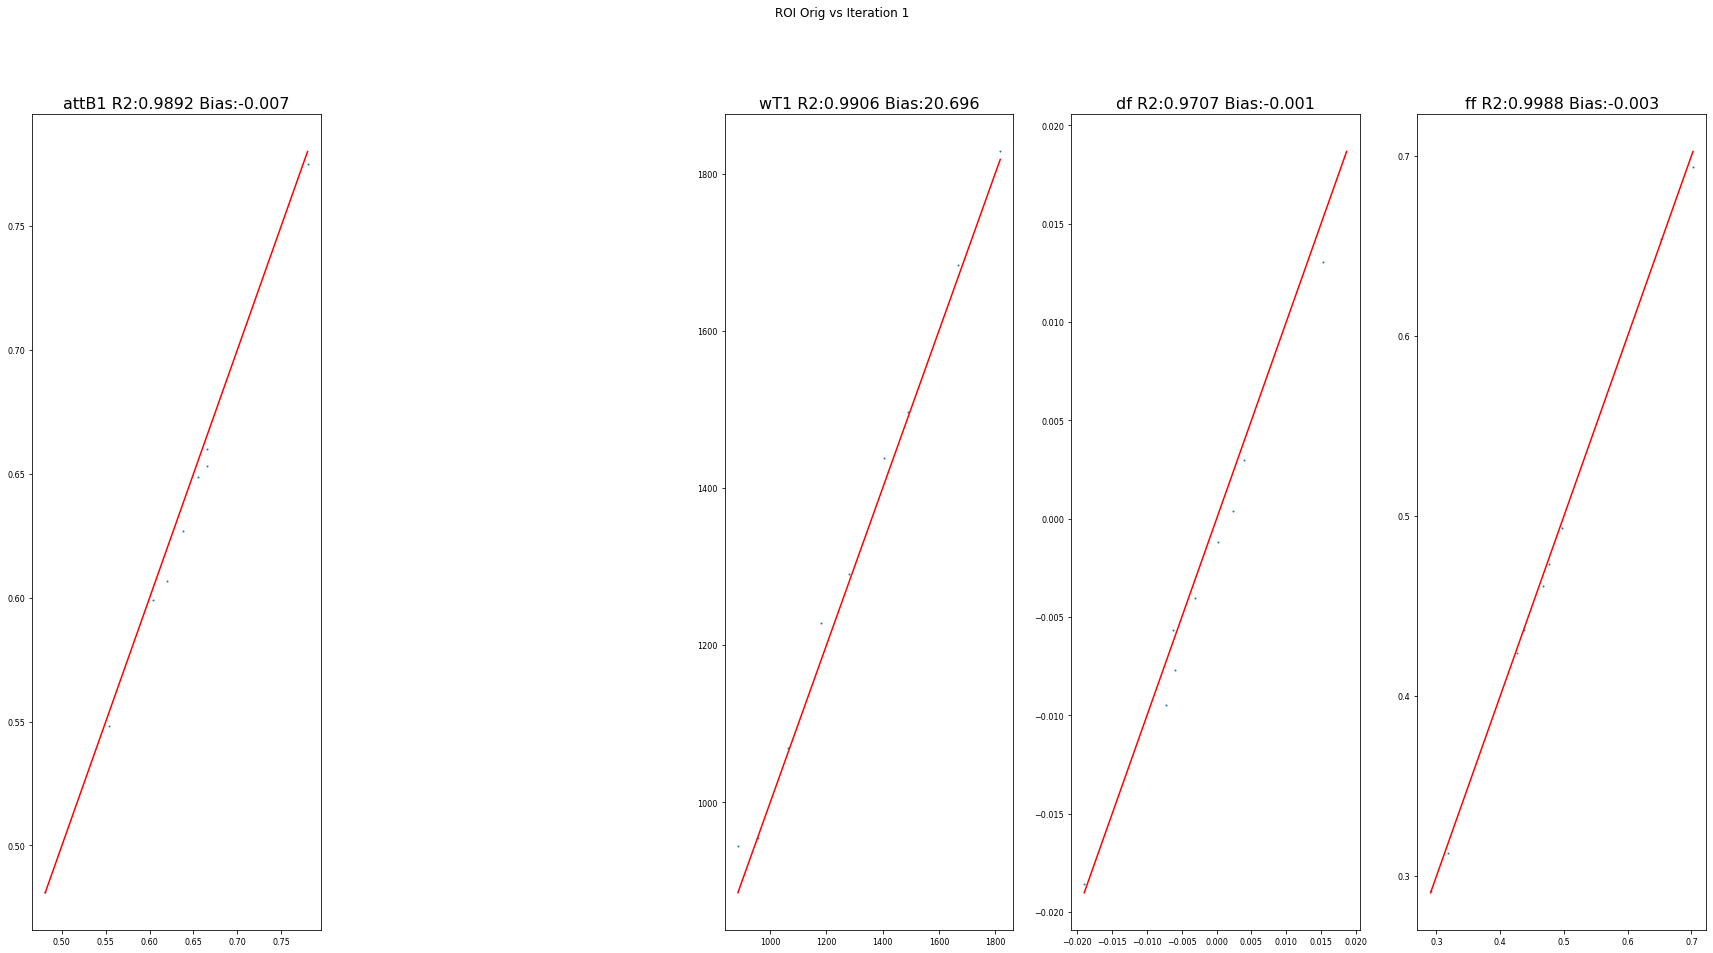

In [109]:
#import importlib

#importlib.reload(utils_mrf)

#
it = 1

regression_paramMaps_ROI(m.paramMap, all_maps_adj[it][0], m.mask > 0, all_maps_adj[it][1] > 0,
                             title="ROI Orig vs Iteration {}".format(it), proj_on_mask1=True, adj_wT1=True, fat_threshold=0.7,figsize=(30,15))

In [78]:
all_maps_adj.items()

/home/cslioussarenko/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


dict_items([(0, ({'wT1': array([1600., 1700., 1900., ..., 1900., 2000., 1700.]), 'fT1': array([300., 300., 300., ..., 300., 300., 300.]), 'attB1': array([0.6 , 0.75, 0.7 , ..., 1.  , 1.  , 1.  ]), 'df': array([-0.   , -0.   , -0.015, ...,  0.015,  0.015,  0.015]), 'ff': array([0.50251473, 0.43761486, 0.39399807, ..., 0.29216742, 0.29650531,
       0.27554803])}, array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]]))), (1, ({'wT1': array([1560., 1520., 1650., ..., 1750., 1850., 1600.]), 'fT1': array([300., 300., 300., ..., 300., 300., 300.]), 'attB1': array([0.3 , 0.3 , 0.3 , ..., 1.  , 1.  , 0.95]), 'df': array([-0.015, -0.015, -0.015, ...,  0.015,  0.015,  0.03 ]), 'ff': array([0.59521476, 0.58333811, 0.58000197, ..., 0.35025235, 0.34964788,
       0.35052819])}, array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0,

In [18]:
def plot_evolution_params(map_ref, mask_ref, all_maps,maskROI=None, adj_wT1=True, metric="R2", fat_threshold=0.7,
                          proj_on_mask1=True, fontsize=5, figsize=(15, 40)):
    keys_1 = set(map_ref.keys())
    keys_2 = set(all_maps[0][0].keys())
    nb_keys = len(keys_1 & keys_2)
    fig, ax = plt.subplots(nb_keys, figsize=figsize)

    if maskROI is None:
        maskROI = buildROImask(map_ref)

    for i, k in enumerate(keys_1 & keys_2):
        print(i)
        result_list = []
        std_list=[]
        for it, value in all_maps.items():

            map2 = value[0]
            mask2 = value[1] > 0

            mask_union = mask_ref | mask2
            mat_obs = makevol(map_ref[k], mask_ref)
            mat_pred = makevol(map2[k], mask2)
            mat_ROI = makevol(maskROI, mask_ref)
            if proj_on_mask1:
                mat_pred = mat_pred * (mask_ref * 1)
                mat_obs = mat_obs * (mask_ref * 1)
                mat_ROI = mat_ROI * (mask_ref * 1)
                mask_union=mask_ref

            obs = mat_obs[mask_union]
            pred = mat_pred[mask_union]
            maskROI_current = mat_ROI[mask_union]

            if adj_wT1 and k == "wT1":
                ff = makevol(map_ref["ff"],mask_ref)
                ff=ff[mask_union]
                obs = obs[ff < fat_threshold]
                pred = pred[ff < fat_threshold]
                maskROI_current = maskROI_current[ff < fat_threshold]
            
            

            df_obs = pd.DataFrame(columns=["Data", "Groups"],
                                  data=np.stack([obs.flatten(), maskROI_current.flatten()], axis=-1))
            df_pred = pd.DataFrame(columns=["Data", "Groups"],
                                   data=np.stack([pred.flatten(), maskROI_current.flatten()], axis=-1))
            mean_obs = np.array(df_obs.groupby("Groups").mean())[1:]
            mean_pred = np.array(df_pred.groupby("Groups").mean())[1:]

            x_min = np.min(mean_obs)
            x_max = np.max(mean_pred)

            if x_min == x_max:
                fig.delaxes(ax[i])
                break

            if metric=="R2":
                mean = np.mean(mean_obs)
                ss_tot = np.sum((mean_obs - mean) ** 2)
                ss_res = np.sum((mean_obs - mean_pred) ** 2)
                bias = np.mean((mean_pred - mean_obs))
                r_2 = 1 - ss_res / ss_tot
                result_list.append(r_2)

            elif metric=="RMSE":
                print(obs.shape)
                print(pred.shape)
                df_error = pd.DataFrame(columns=["Data", "Groups"],
                             data=np.stack([(pred.flatten()-obs.flatten())**2, maskROI_current.flatten()], axis=-1))
                errors = np.sqrt(np.array(df_error.groupby("Groups").mean())[1:])
                error = np.mean(errors)
                std_error = np.std(errors)
                result_list.append(error)
                std_list.append(std_error)
            else:
                raise ValueError("Metric should be RMSE or R2")

        n_it = len(result_list)
        if metric == "R2":
            ax[i].plot(range(n_it), result_list, "r")
        elif metric == "RMSE":
            #ax[i].plot(range(n_it), result_list, "r")
            ax[i].errorbar(range(n_it), result_list,std_list)


        ax[i].set_title(k + " Evolution over Iteration", fontsize=2 * fontsize)
        ax[i].tick_params(axis='x', labelsize=fontsize)
        ax[i].tick_params(axis='y', labelsize=fontsize)

    plt.suptitle("{} Evolution".format(metric))

/home/cslioussarenko/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0
(9000,)
(9000,)
(9000,)
(9000,)
(9000,)
(9000,)
(9000,)
(9000,)
(9000,)
(9000,)
(9000,)
(9000,)
(9000,)
(9000,)
(9000,)
(9000,)
(9000,)
(9000,)
(9000,)
(9000,)
(9000,)
(9000,)
1
(6600,)
(6600,)
(6600,)
(6600,)
(6600,)
(6600,)
(6600,)
(6600,)
(6600,)
(6600,)
(6600,)
(6600,)
(6600,)
(6600,)
(6600,)
(6600,)
(6600,)
(6600,)
(6600,)
(6600,)
(6600,)
(6600,)
2
(9000,)
(9000,)
(9000,)
(9000,)
(9000,)
(9000,)
(9000,)
(9000,)
(9000,)
(9000,)
(9000,)
(9000,)
(9000,)
(9000,)
(9000,)
(9000,)
(9000,)
(9000,)
(9000,)
(9000,)
(9000,)
(9000,)
3
(9000,)
(9000,)
(9000,)
(9000,)
(9000,)
(9000,)
(9000,)
(9000,)
(9000,)
(9000,)
(9000,)
(9000,)
(9000,)
(9000,)
(9000,)
(9000,)
(9000,)
(9000,)
(9000,)
(9000,)
(9000,)
(9000,)
4


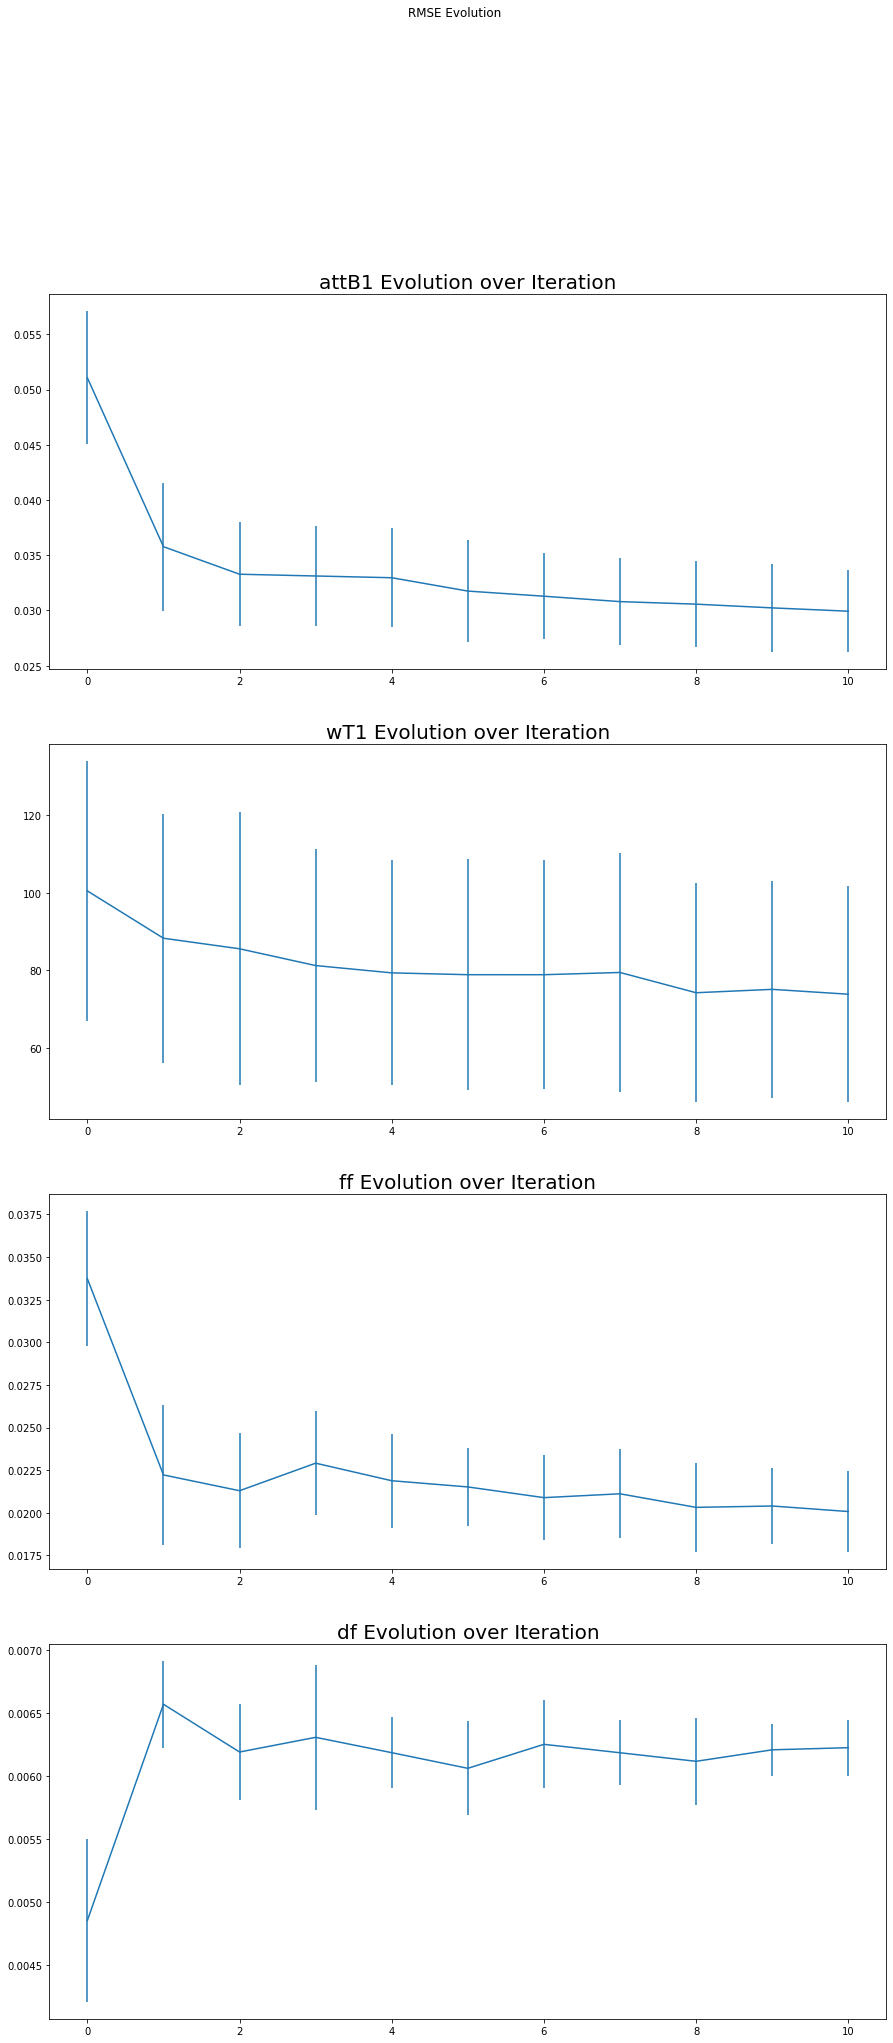

In [23]:
plot_evolution_params(m.paramMap,m.mask>0,all_maps_adj,metric="RMSE",fontsize=10,adj_wT1=True)

/home/cslioussarenko/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[0.2811607  0.2876478  0.46386022 0.46546829 0.46895714 0.49735998
 0.55445136 0.57659037 0.65215036]


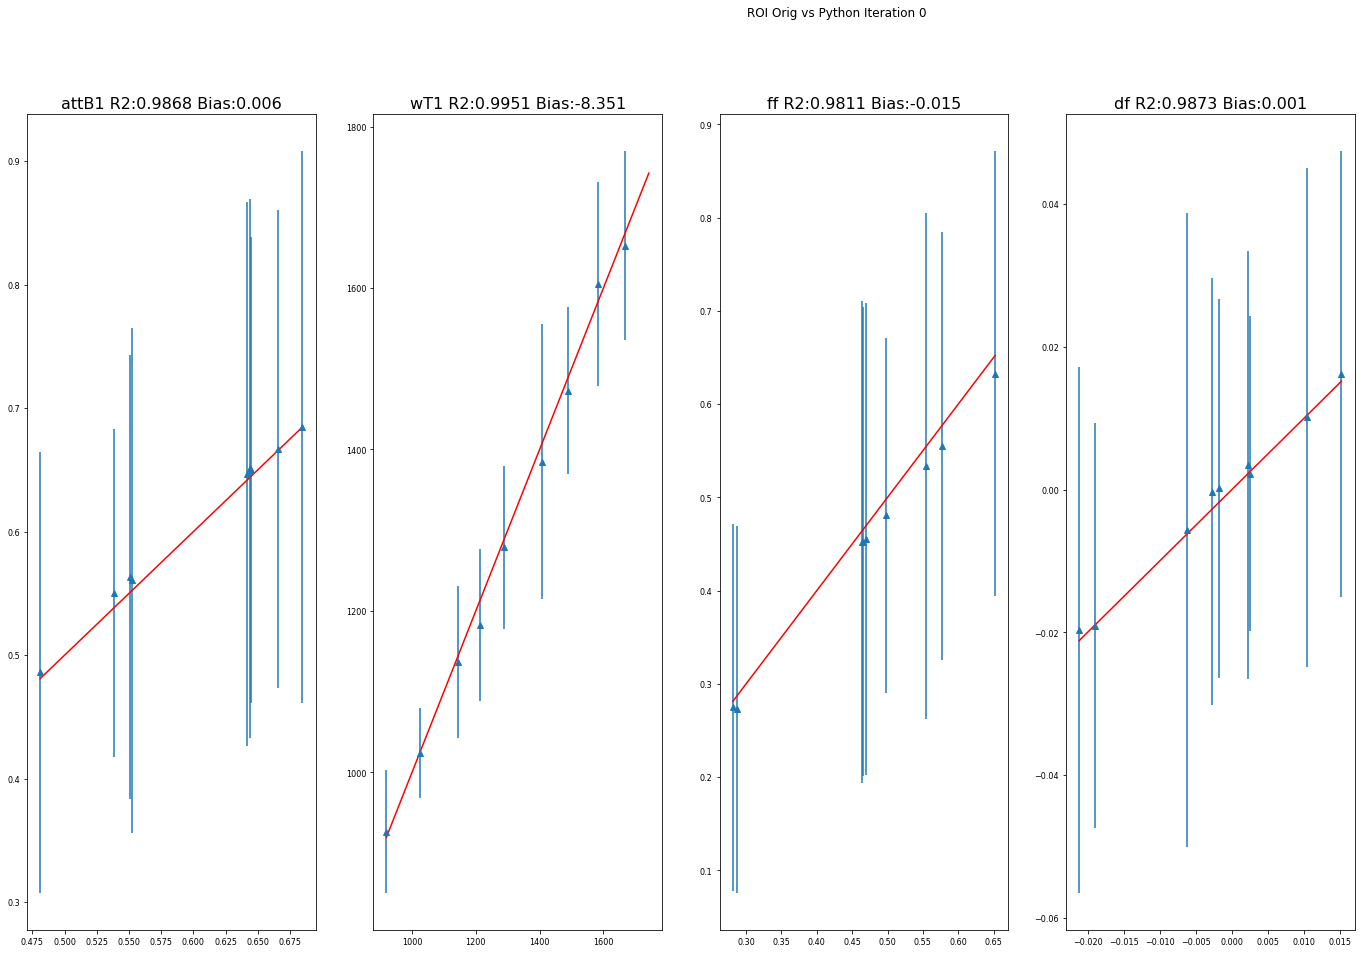

In [51]:
#import importlib

#importlib.reload(utils_mrf)

#
maskROI=buildROImask(m.paramMap)

it = 0

regression_paramMaps_ROI(m.paramMap, all_maps_adj[it][0], m.mask > 0, all_maps_adj[it][1] > 0,maskROI=maskROI,
                             title="ROI Orig vs Python Iteration {}".format(it), proj_on_mask1=True, adj_wT1=True, fat_threshold=0.7,figsize=(30,15),fontsize=8)

/home/cslioussarenko/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[0.2811607  0.2876478  0.46386022 0.46546829 0.46895714 0.49735998
 0.55445136 0.57659037 0.65215036]


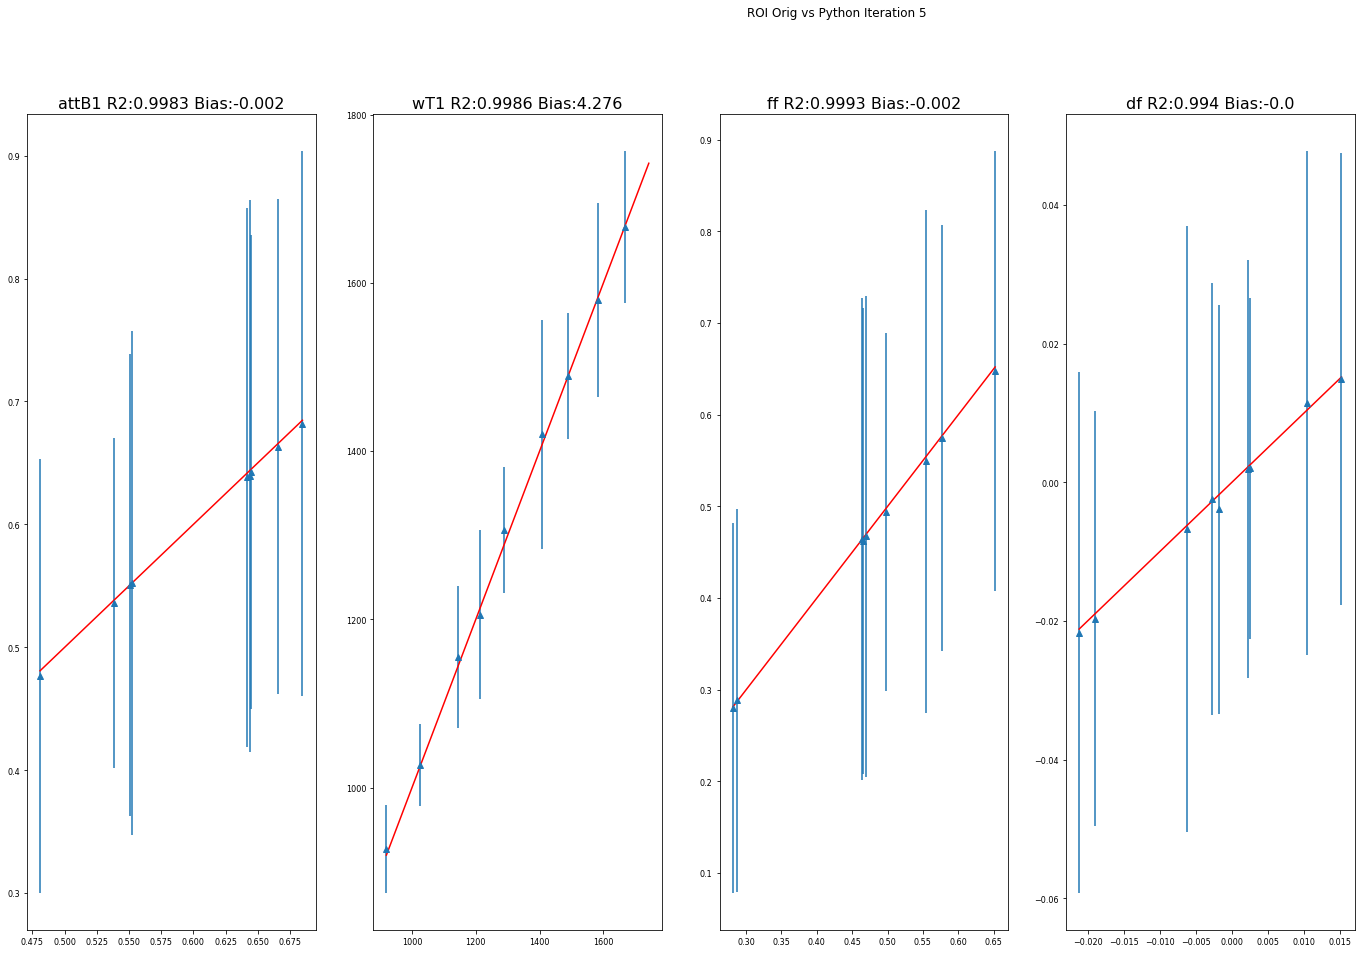

In [53]:
#import importlib

#importlib.reload(utils_mrf)

#


it = 5

regression_paramMaps_ROI(m.paramMap, all_maps_adj[it][0], m.mask > 0, all_maps_adj[it][1] > 0,maskROI=maskROI,
                             title="ROI Orig vs Python Iteration {}".format(it), proj_on_mask1=True, adj_wT1=True, fat_threshold=0.7,figsize=(30,15),fontsize=8)

/home/cslioussarenko/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[0.2811607  0.2876478  0.46386022 0.46546829 0.46895714 0.49735998
 0.55445136 0.57659037 0.65215036]


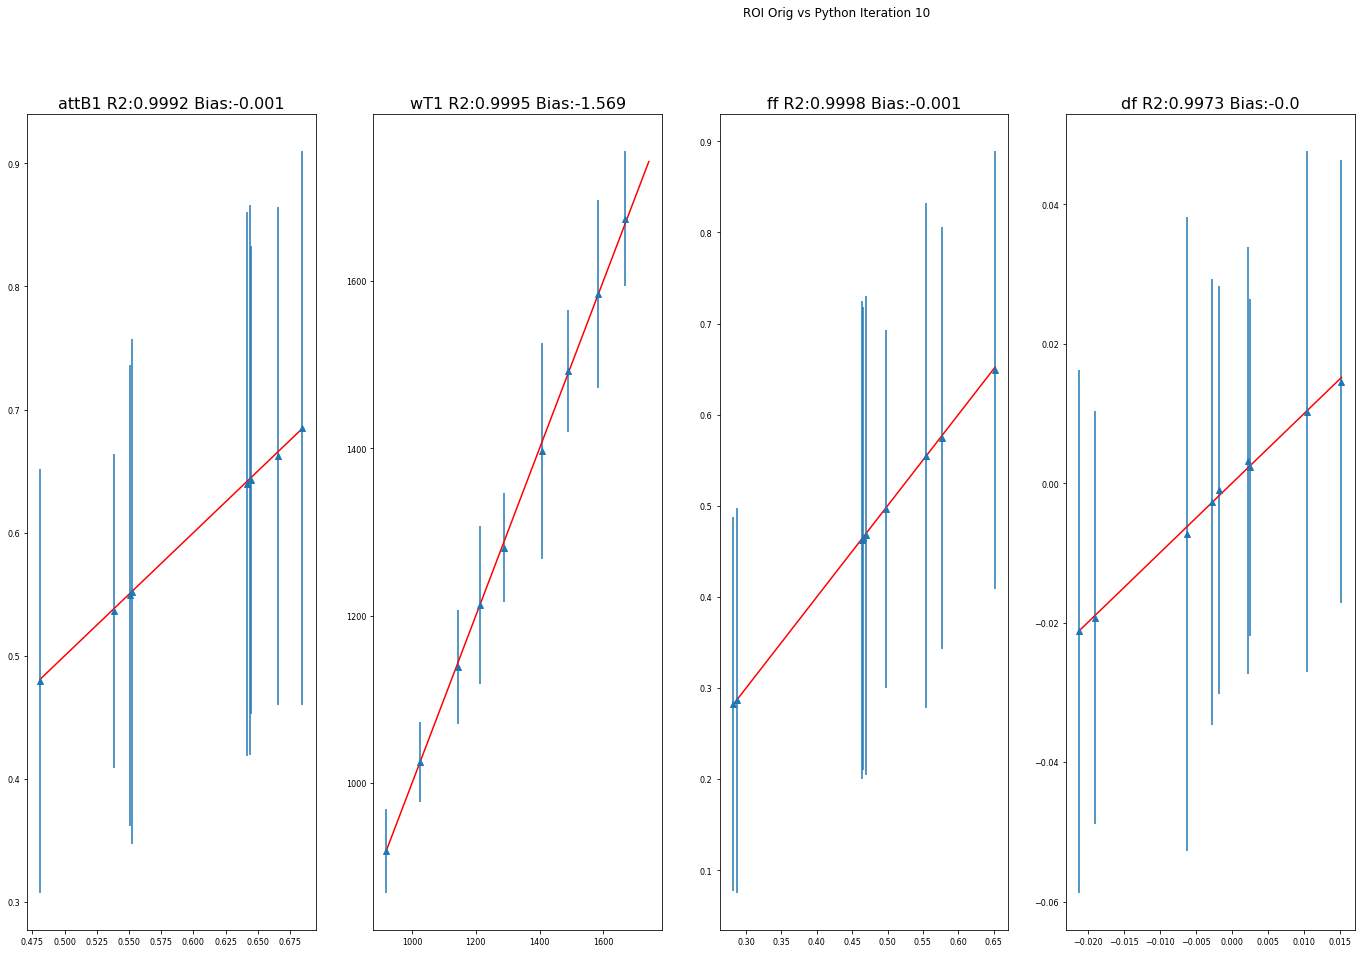

In [52]:
#import importlib

#importlib.reload(utils_mrf)

#


it = 10

regression_paramMaps_ROI(m.paramMap, all_maps_adj[it][0], m.mask > 0, all_maps_adj[it][1] > 0,maskROI=maskROI,
                             title="ROI Orig vs Python Iteration {}".format(it), proj_on_mask1=True, adj_wT1=True, fat_threshold=0.7,figsize=(30,15),fontsize=8)

/home/cslioussarenko/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[0.2811607  0.2876478  0.46386022 0.46546829 0.46895714 0.49735998
 0.55445136 0.57659037 0.65215036]


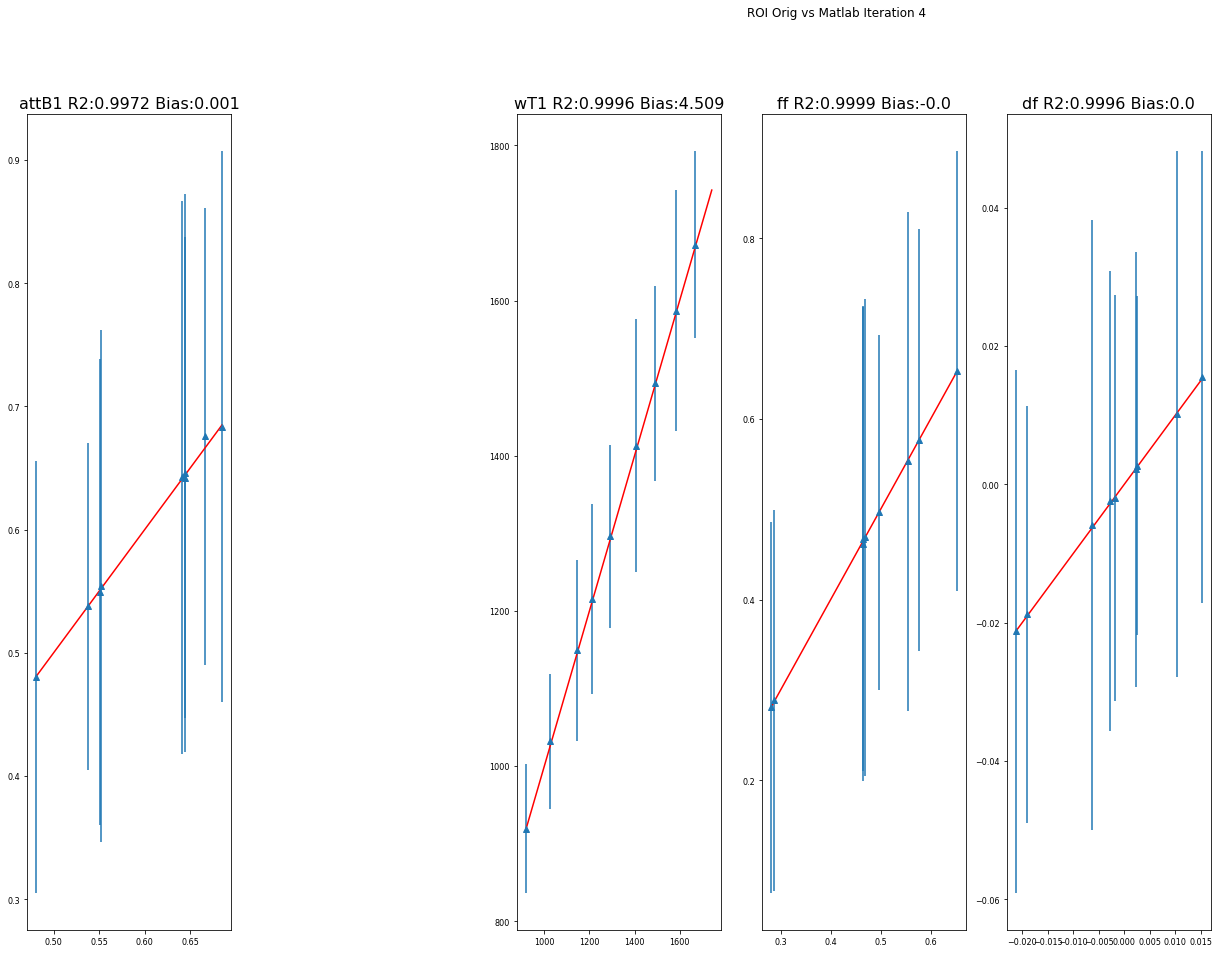

In [64]:

regression_paramMaps_ROI(m.paramMap, map_rebuilt_Matlab.paramMap, m.mask > 0, map_rebuilt_Matlab.mask > 0,maskROI=maskROI,
                             title="ROI Orig vs Matlab Iteration 4", proj_on_mask1=True, adj_wT1=True, fat_threshold=0.7,figsize=(30,15),fontsize=8)

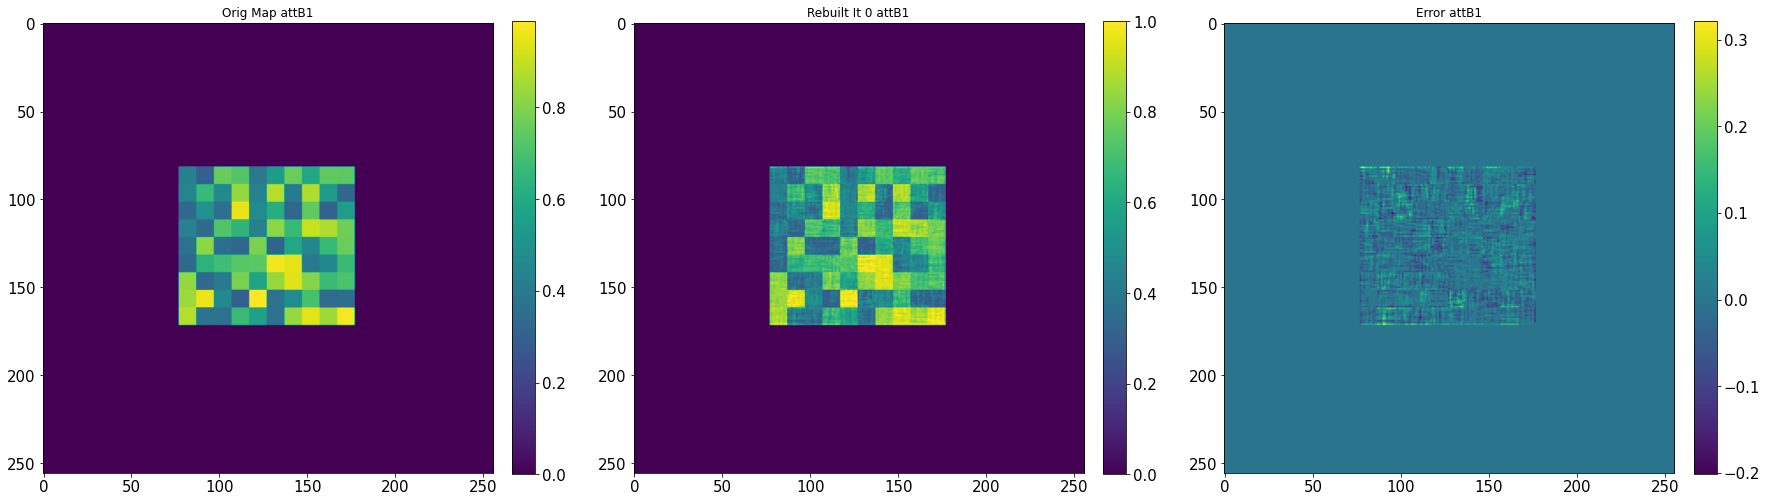

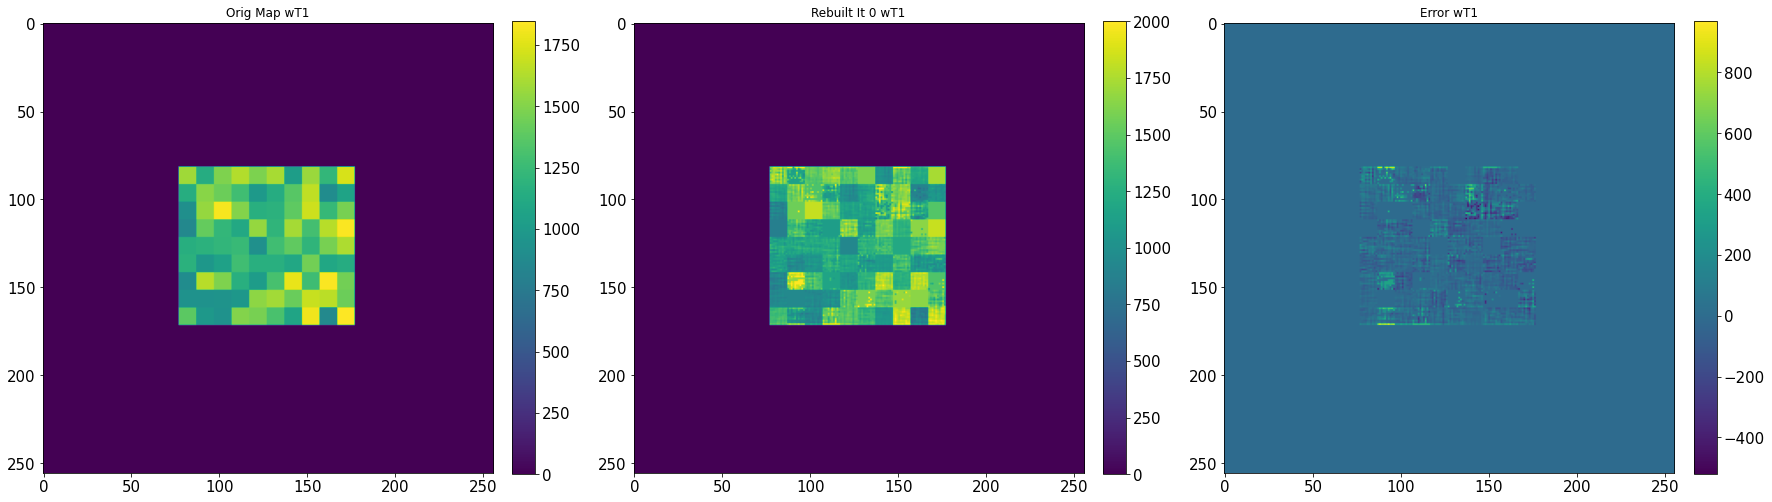

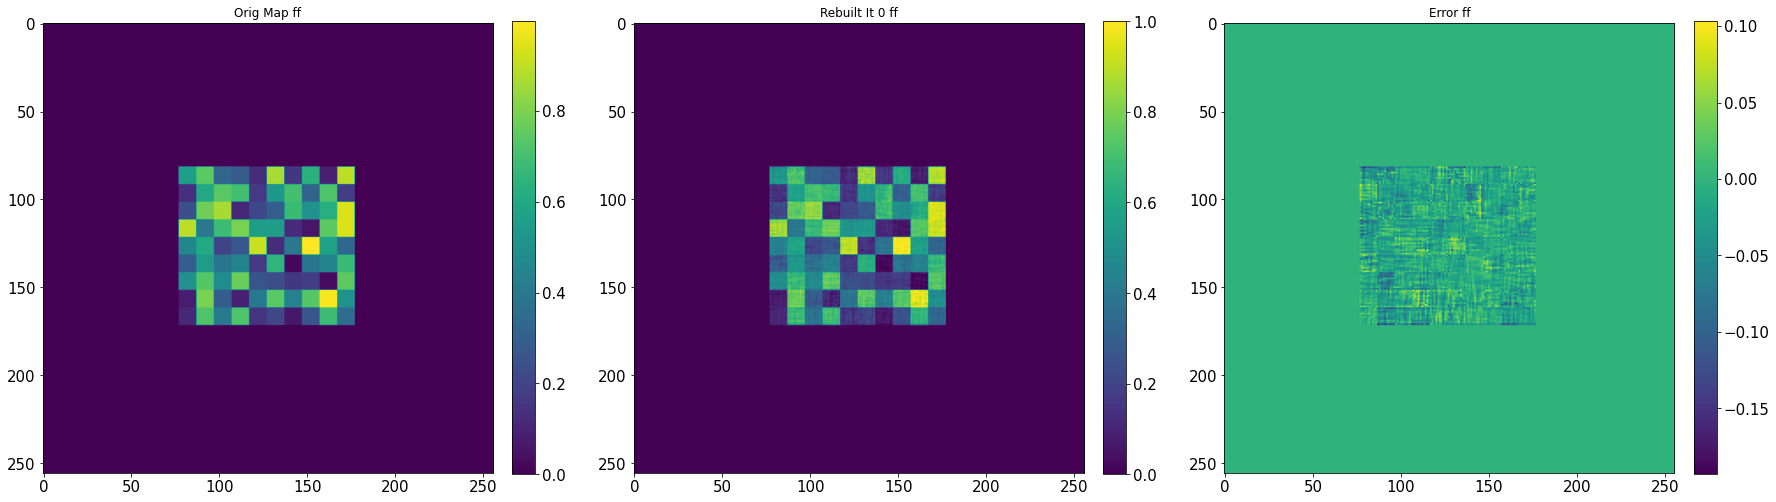

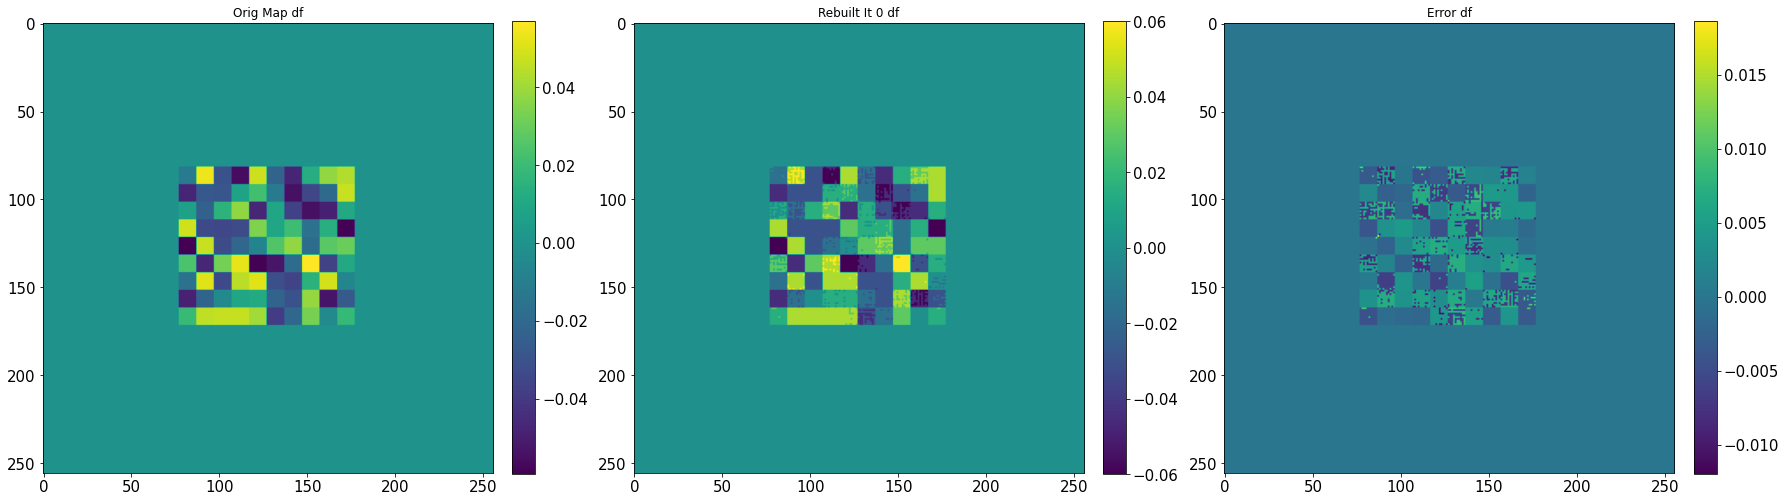

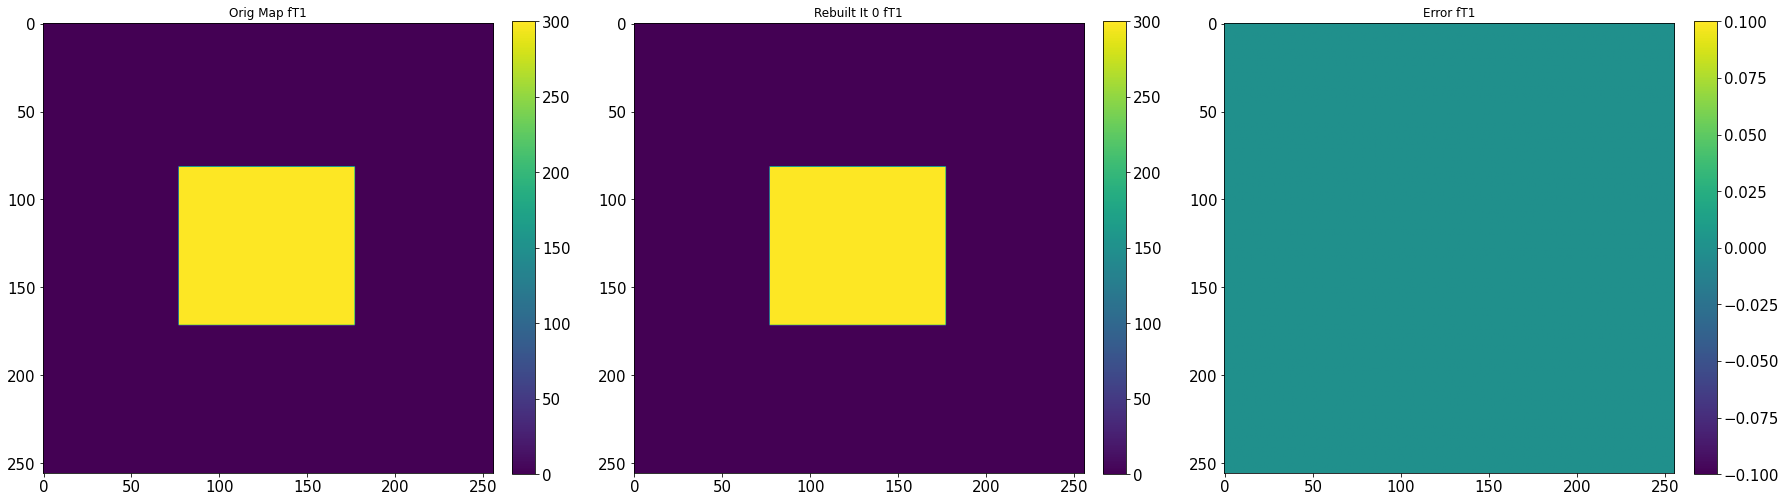

In [61]:
it=0
compare_paramMaps(m.paramMap,all_maps_adj[it][0],m.mask>0,all_maps_adj[it][1]>0,adj_wT1=True,fat_threshold=0.7,title2="Rebuilt It {}".format(it),figsize=(30,10),fontsize=15)

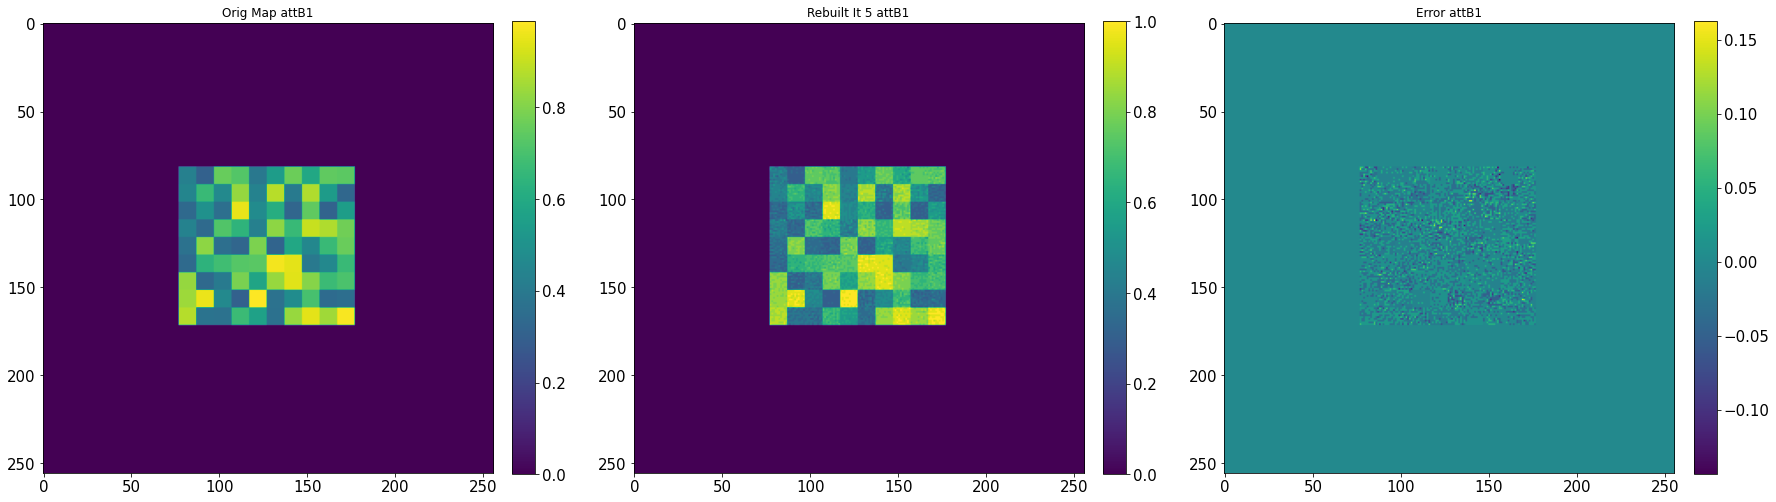

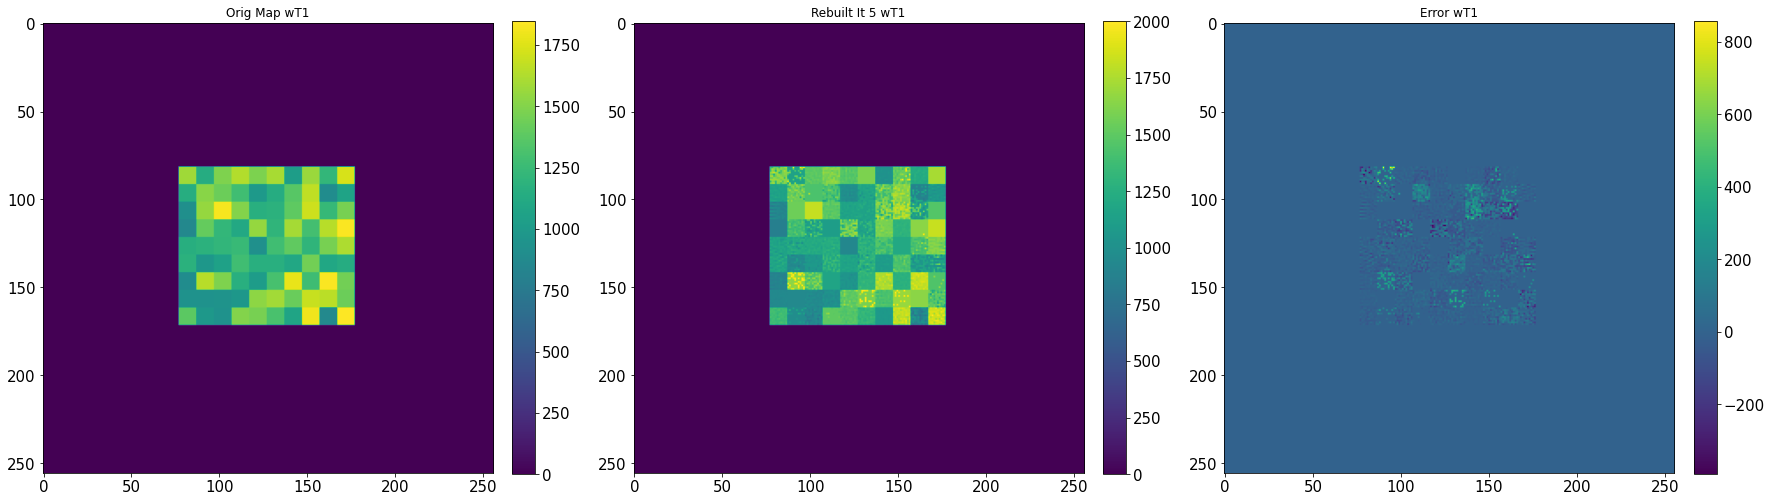

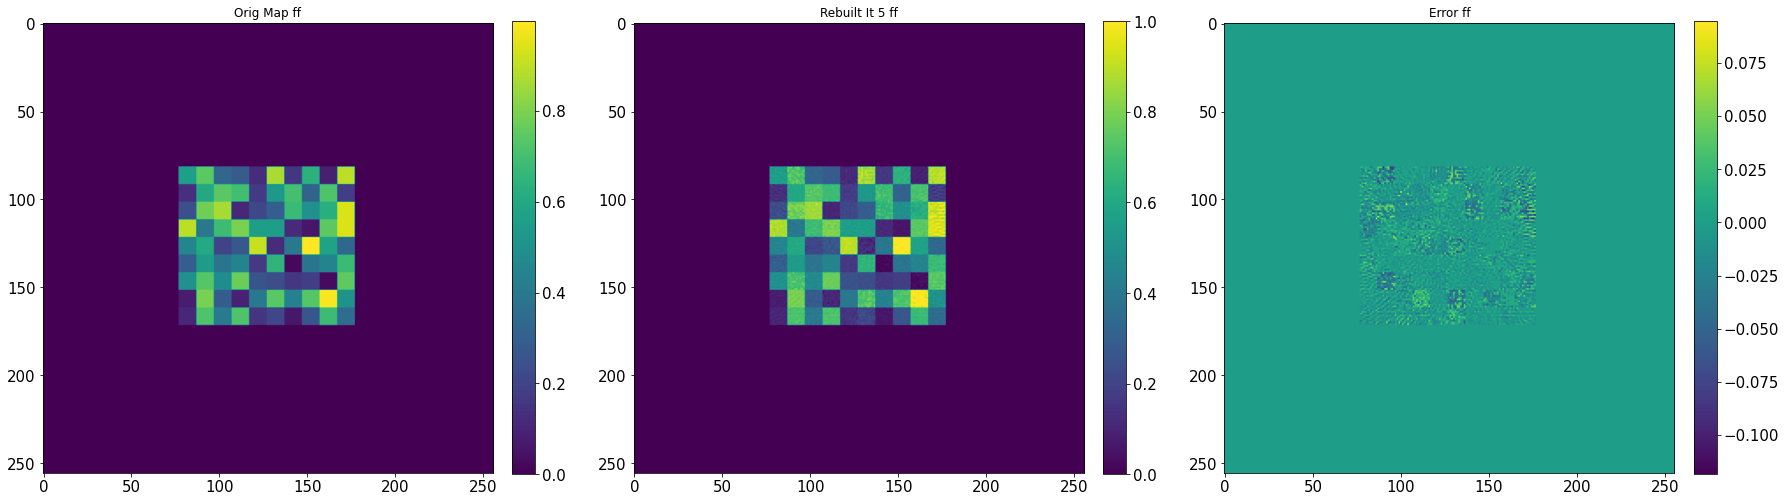

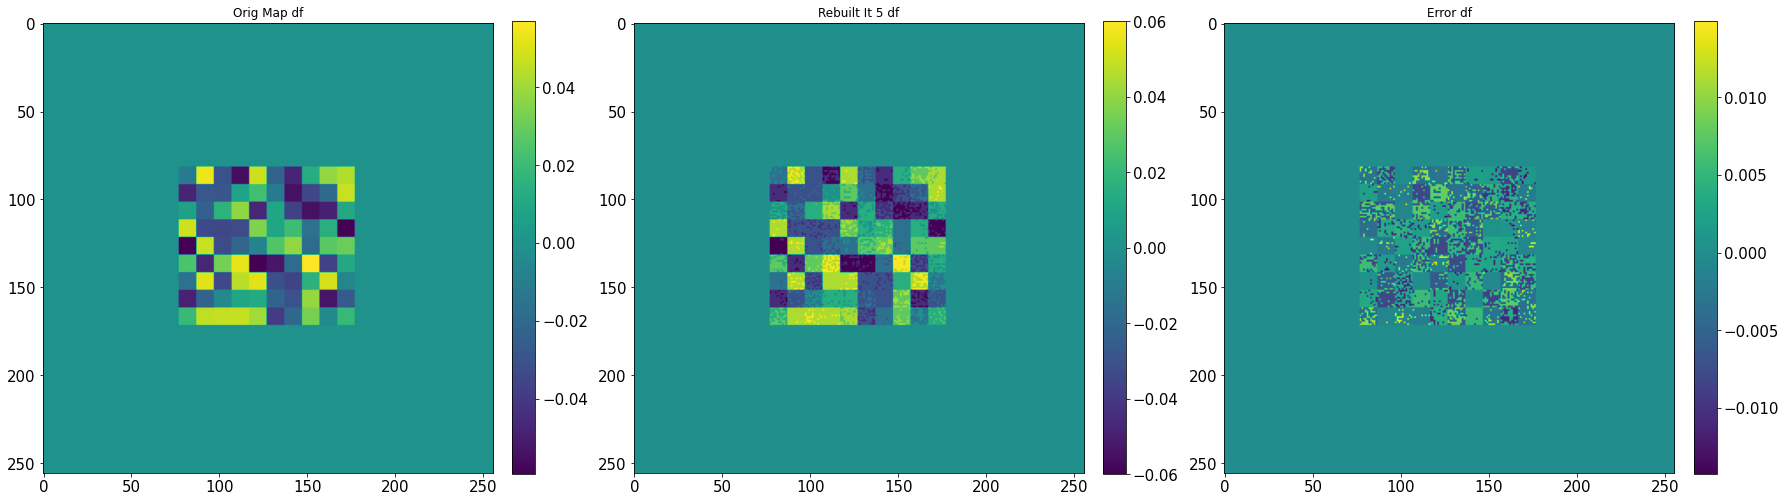

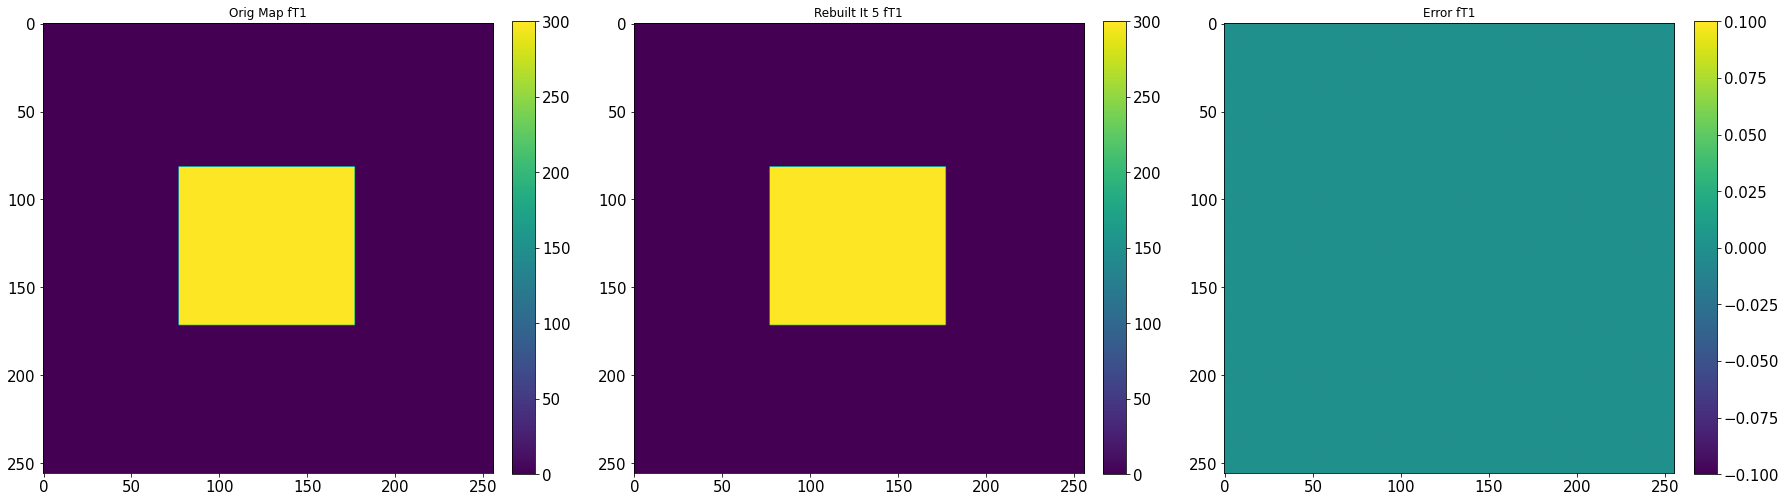

In [62]:
it=5
compare_paramMaps(m.paramMap,all_maps_adj[it][0],m.mask>0,all_maps_adj[it][1]>0,adj_wT1=True,fat_threshold=0.7,title2="Rebuilt It {}".format(it),figsize=(30,10),fontsize=15)

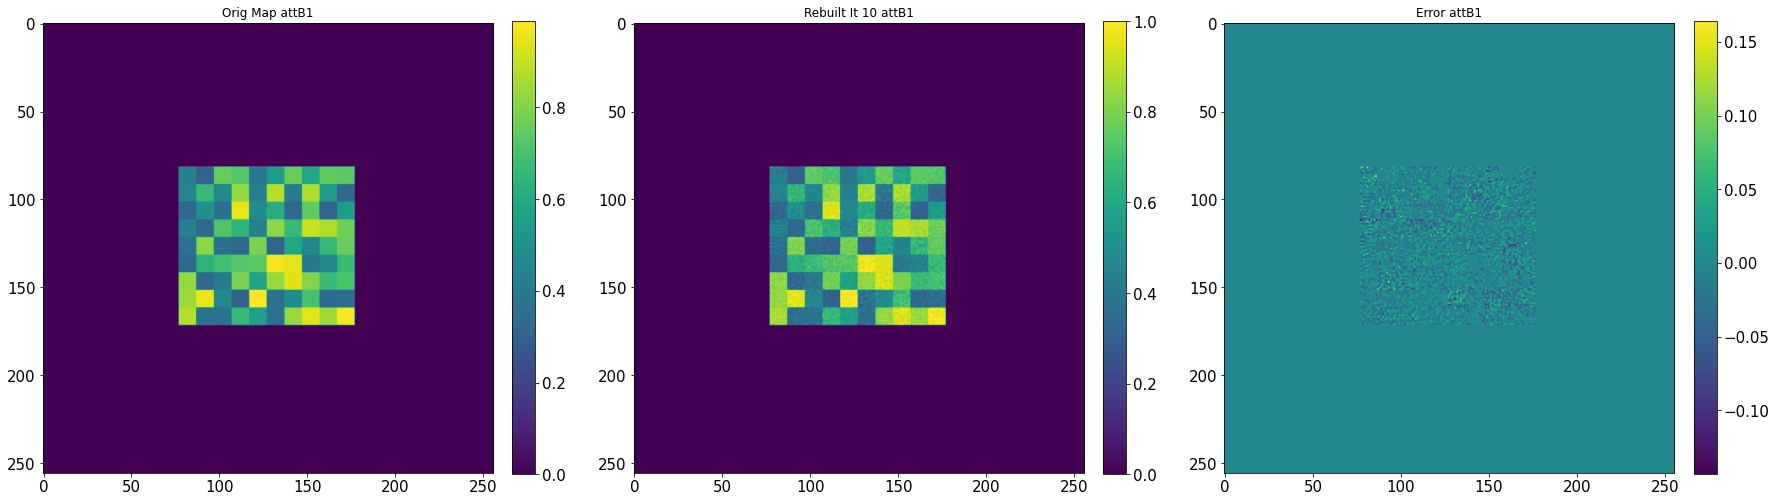

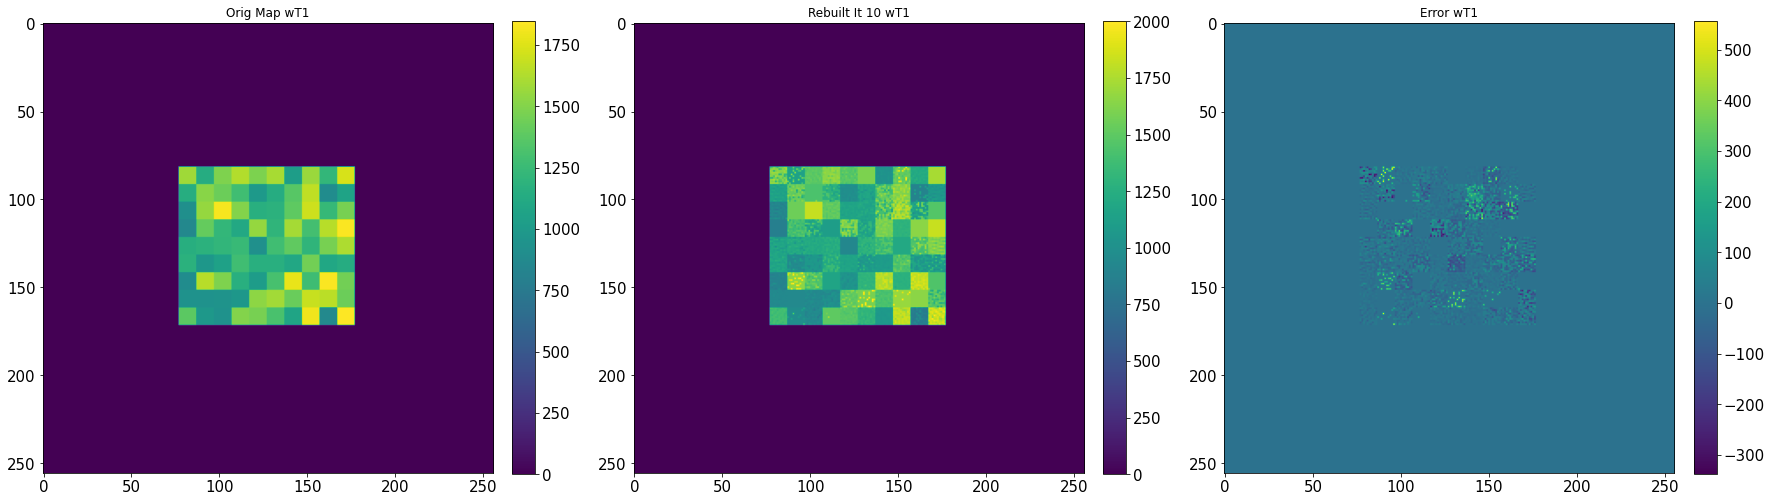

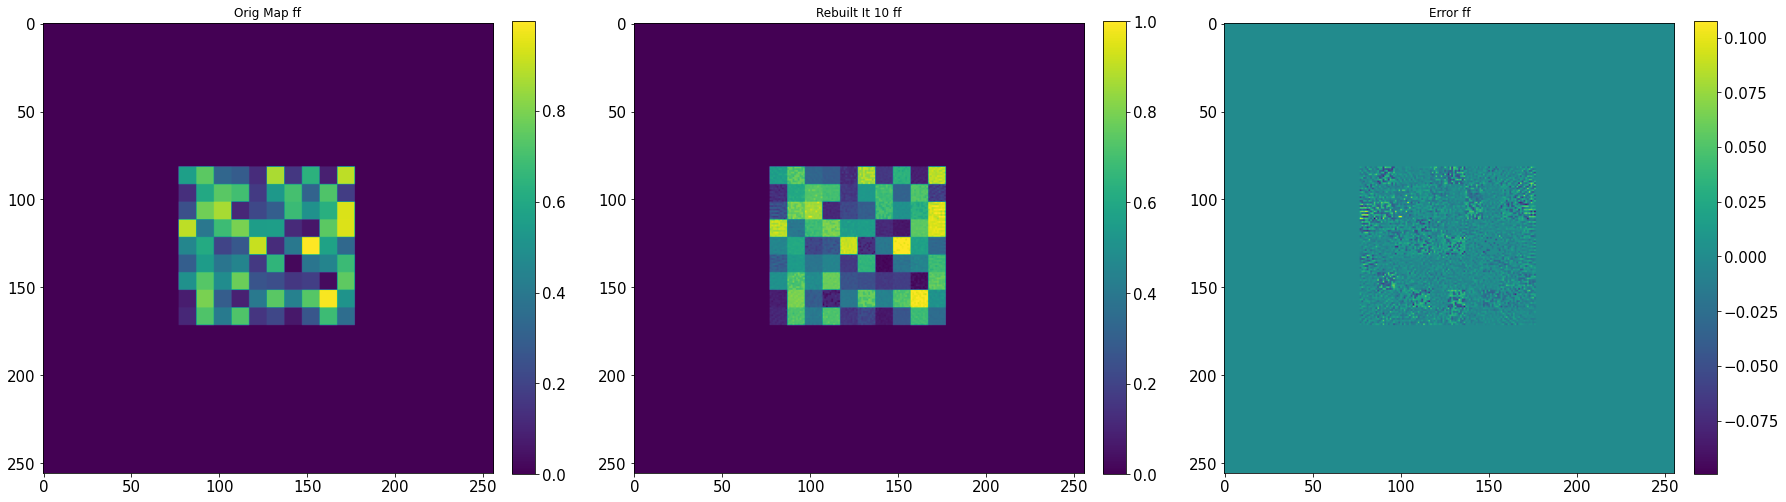

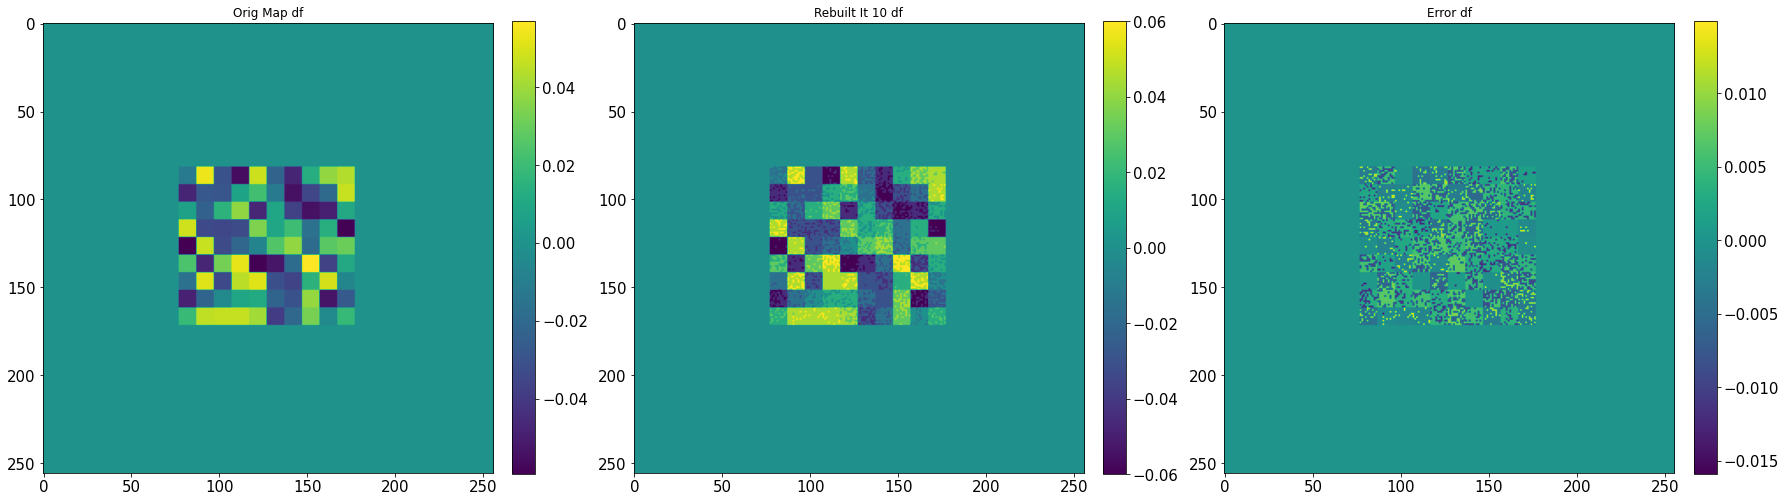

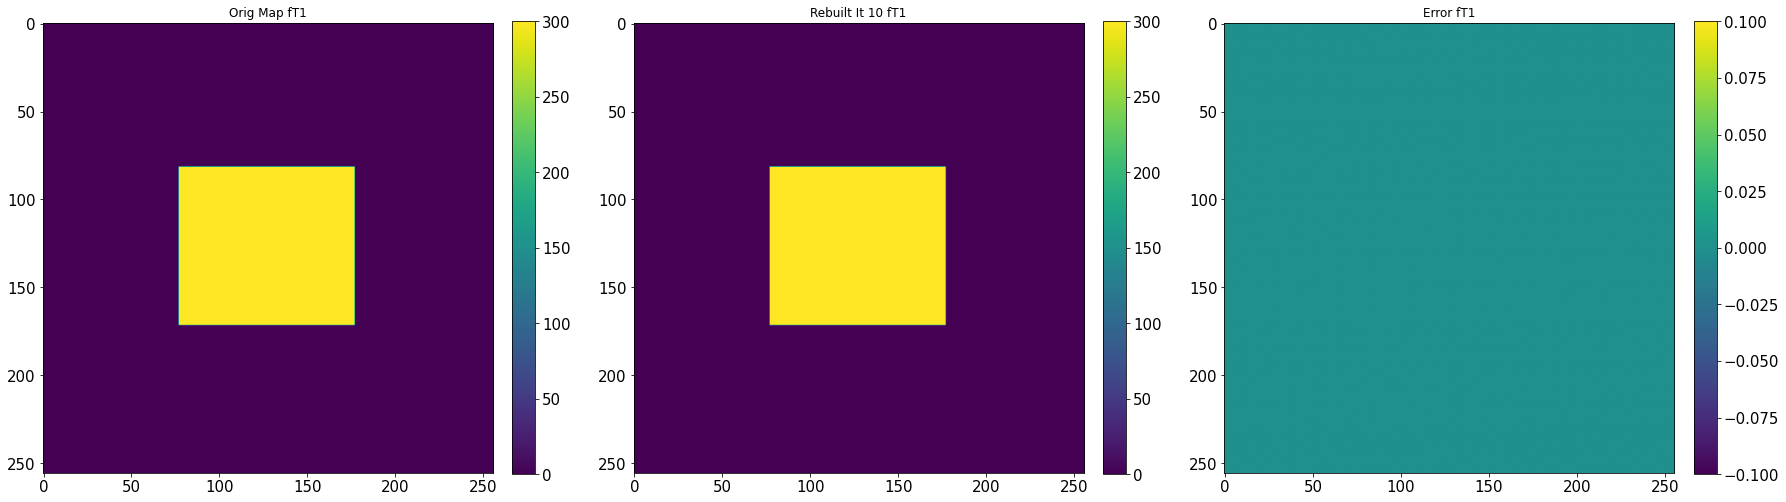

In [63]:
it=10
compare_paramMaps(m.paramMap,all_maps_adj[it][0],m.mask>0,all_maps_adj[it][1]>0,adj_wT1=True,fat_threshold=0.7,title2="Rebuilt It {}".format(it),figsize=(30,10),fontsize=15)

In [156]:
np.unique(m.paramMap["fT1"])

array([350.])

In [155]:
np.unique(map_rebuilt_Matlab.paramMap["fT1"])

array([300.])

In [ ]:
map_rebuilt_Matlab.plotParamMap("ff")

# Compare Param Map

In [165]:
makevol(m.paramMap["wT1"],m.mask>0)[82,77]==1586

True

In [167]:
makevol(m.paramMap["ff"],m.mask>0)[82,77]==0.5619

False

In [186]:
makevol(m.paramMap["df"],m.mask>0)[82,77]==-11.6654/1000

False

In [187]:
makevol(m.paramMap["df"],m.mask>0)[82,77]

-0.012

In [189]:
makevol(m.paramMap["attB1"],m.mask>0)[82,77]==0.4289

False

In [190]:
makevol(m.paramMap["attB1"],m.mask>0)[82,77]

0.43

In [185]:
makevol(map_rebuilt_Matlab.paramMap["df"],map_rebuilt_Matlab.mask>0)[82,77]

/home/cslioussarenko/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


-0.015

# Compare sequence

In [169]:
param_seq={"TI": 8.32, "FA": 5, "TE": [2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 2.39, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 3.45, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63], "TR": [3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 3.52, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 4.58, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76], "B1": [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]}

In [175]:
param_seq.keys()

dict_keys(['TI', 'FA', 'TE', 'TR', 'B1'])

In [174]:
np.unique(np.array(param_seq["TR"])-np.array(param_seq["TE"]))

array([1.13])

In [172]:
np.max(np.abs(np.array(param_seq["TE"])-matlab_TE))

0.0

In [177]:
np.max(np.abs(np.array(param_seq["B1"])-matlab_B1))

0.0

# Param Dico

In [9]:
paramDico_matlab = loadmat("./Data_Matlab/paramDico_empty.mat")

/home/cslioussarenko/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [45]:
paramDico_matlab["paramDico"]

array([[(array([[2]], dtype=uint8), array([[array([[40]], dtype=uint8), array([[80]], dtype=uint8)]],
              dtype=object), array([[0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
                0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]]), array([[0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 ,
                0.85, 0.9 , 0.95, 1.  ]]), array([[-60, -45, -30, -15,   0,  15,  30,  45,  60]], dtype=int16), array([[array([[180]], dtype=uint8), array([[180]], dtype=uint8)]],
              dtype=object), array([[array([[ 550,  560,  570,  580,  590,  600,  610,  620,  630,  640,  650,
                         660,  670,  680,  690,  700,  710,  720,  730,  740,  750,  760,
                         770,  780,  790,  800,  810,  820,  830,  840,  850,  860,  870,
                         880,  890,  900,  910,  920,  930,  940,  950,  960,  970,  980,
                         990, 1000, 1010, 1020, 1030, 1040, 1050, 1060, 1070, 108

In [46]:
list(paramDico_matlab["paramDico"]["FA"][0,0][0])

[0.3,
 0.35,
 0.4,
 0.45,
 0.5,
 0.55,
 0.6000000000000001,
 0.6499999999999999,
 0.7,
 0.75,
 0.8,
 0.85,
 0.9,
 0.95,
 1.0]

In [47]:
list(paramDico_matlab["paramDico"]["Df"][0,0][0])

[-60, -45, -30, -15, 0, 15, 30, 45, 60]

In [48]:
list(paramDico_matlab["paramDico"]["T2"][0,0][0])

[array([[40]], dtype=uint8), array([[80]], dtype=uint8)]

In [44]:
list(paramDico_matlab["paramDico"]["FF"][0,0][0])

[0.0,
 0.05,
 0.1,
 0.15000000000000002,
 0.2,
 0.25,
 0.30000000000000004,
 0.35000000000000003,
 0.4,
 0.45,
 0.5,
 0.55,
 0.6,
 0.6499999999999999,
 0.7,
 0.75,
 0.8,
 0.85,
 0.9,
 0.95,
 1.0]

In [36]:
list(paramDico_matlab["paramDico"]["T1"][0,0][0,0][0])

[550,
 560,
 570,
 580,
 590,
 600,
 610,
 620,
 630,
 640,
 650,
 660,
 670,
 680,
 690,
 700,
 710,
 720,
 730,
 740,
 750,
 760,
 770,
 780,
 790,
 800,
 810,
 820,
 830,
 840,
 850,
 860,
 870,
 880,
 890,
 900,
 910,
 920,
 930,
 940,
 950,
 960,
 970,
 980,
 990,
 1000,
 1010,
 1020,
 1030,
 1040,
 1050,
 1060,
 1070,
 1080,
 1090,
 1100,
 1110,
 1120,
 1130,
 1140,
 1150,
 1160,
 1170,
 1180,
 1190,
 1200,
 1210,
 1220,
 1230,
 1240,
 1250,
 1260,
 1270,
 1280,
 1290,
 1300,
 1310,
 1320,
 1330,
 1340,
 1350,
 1360,
 1370,
 1380,
 1390,
 1400,
 1410,
 1420,
 1430,
 1440,
 1450,
 1460,
 1470,
 1480,
 1490,
 1500,
 1510,
 1520,
 1530,
 1540,
 1550,
 1560,
 1570,
 1580,
 1590,
 1600,
 1650,
 1700,
 1750,
 1800,
 1850,
 1900,
 1950,
 2000]

In [37]:
list(paramDico_matlab["paramDico"]["T1"][0,0][0,1][0])

[300]

# Compare Simulation Ideal

In [6]:
sim_matlab = loadmat("./Data_Matlab/ImgSeries_ideal_iter_TestCS0.mat")

In [7]:
sim_matlab['ImgSeries'].shape

(256, 256, 1, 1400)

In [8]:
simulations = np.squeeze(sim_matlab['ImgSeries'])
simulations=np.moveaxis(simulations,-1,0)

In [37]:
simulations_reshaped = simulations.reshape((simulations.shape[0],-1))
window=8
means = [np.mean(gp, axis=0) for gp in groupby(simulations_reshaped, window)]
means=np.array(means)
matlab_means = means.reshape((means.shape[0],simulations.shape[1],-1))

In [41]:
python_means = np.array([np.mean(gp, axis=0) for gp in groupby(m.images_series, window)])

In [73]:
pixel=(125,125)

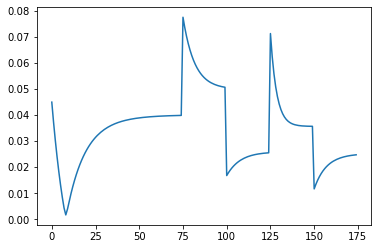

In [74]:
plt.plot(np.abs(m.images_series[:,pixel[0],pixel[1]]))

/home/cslioussarenko/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


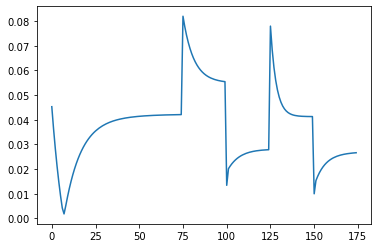

In [75]:
plt.plot(np.abs(simulations_mean[:,pixel[0],pixel[1]]))

In [40]:
python_means

[array([[0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
        ...,
        [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j]]),
 array([[0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
        ...,
        [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j]]),
 array([[0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
        ...,
        [0.+

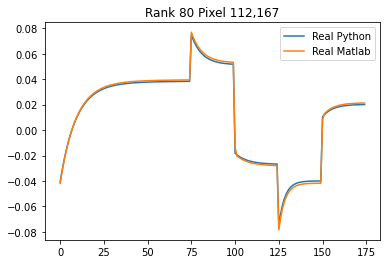

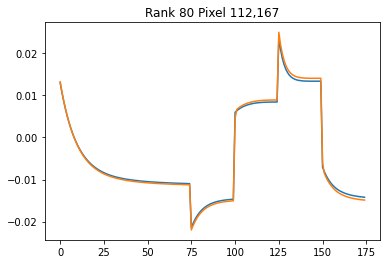

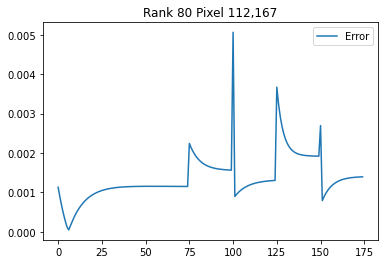

In [49]:
error = np.abs(python_means-matlab_means)
idx_max = np.argmax((error.flatten()))
idx_max=np.unravel_index(idx_max,error.shape)
plt.figure()
plt.plot(np.real(python_means[:,idx_max[1],idx_max[2]]),label="Real Python")
plt.plot(np.real(matlab_means[:,idx_max[1],idx_max[2]]),label="Real Matlab")
plt.title("Rank {} Pixel {},{}".format(rank,idx_max[1],idx_max[2]))
plt.legend()

plt.figure()
plt.plot(np.imag(python_means[:,idx_max[1],idx_max[2]]),label="Imag Python")
plt.plot(np.imag(matlab_means[:,idx_max[1],idx_max[2]]),label="Imag Matlab")
plt.title("Rank {} Pixel {},{}".format(rank,idx_max[1],idx_max[2]))

plt.figure()
plt.plot(np.real(error[:,idx_max[1],idx_max[2]]),label="Error")
plt.title("Rank {} Pixel {},{}".format(rank,idx_max[1],idx_max[2]))



plt.legend()

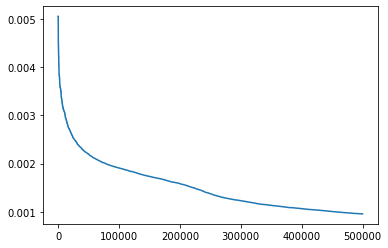

In [48]:
plt.plot(np.sort(error.flatten())[::-1][:500000])

In [44]:
np.argsort(error.flatten())[::-1]

array([6583211, 6582440, 6582442, ..., 7360864, 7360863,       0])

NameError: name 'simulations_mean' is not defined

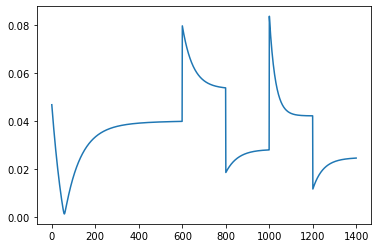

In [152]:


plt.plot(np.abs(m.images_series[:,idx_max[1],idx_max[2]]),label="Python")
plt.plot(np.abs(simulations_mean[:,idx_max[1],idx_max[2]]),label="Matlab")
plt.legend()

In [95]:
idx_max

(125, 132, 127)

In [51]:
window=8
np.ma.average(simulations,weights=np.ones(window),axis=0)

ValueError: Length of weights not compatible with specified axis.

In [94]:
m.build_ref_images(seq,1)

/home/cslioussarenko/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Building Ref Images
Simulating Water Signal
Simulating Fat Signal
Build dictionary.


In [53]:
simulations.shape

(1400, 256, 256)

In [54]:
1400/8

175.0

In [97]:
m.images_series.shape

(1400, 256, 256)

In [98]:
simulations.shape

(1400, 256, 256)

In [ ]:
error_all = np.abs(m.images_series-simulations)

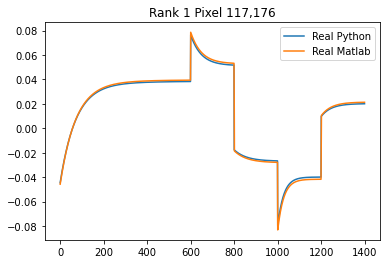

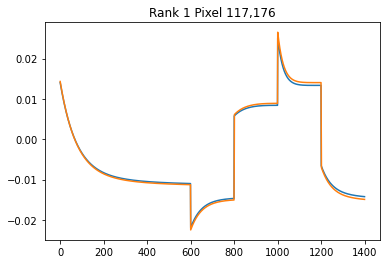

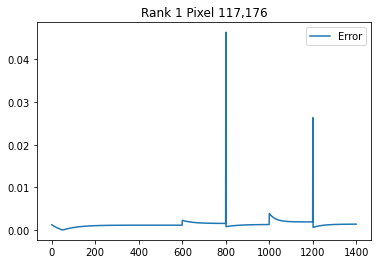

In [104]:

rank=1


idx_max = np.argsort((error_all.flatten()))[-rank]
#idx_max = np.argmax((error_all.flatten()))
idx_max=np.unravel_index(idx_max,error_all.shape)
plt.figure()
plt.plot(np.real(m.images_series[:,idx_max[1],idx_max[2]]),label="Real Python")
plt.plot(np.real(simulations[:,idx_max[1],idx_max[2]]),label="Real Matlab")
plt.title("Rank {} Pixel {},{}".format(rank,idx_max[1],idx_max[2]))
plt.legend()

plt.figure()
plt.plot(np.imag(m.images_series[:,idx_max[1],idx_max[2]]),label="Imag Python")
plt.plot(np.imag(simulations[:,idx_max[1],idx_max[2]]),label="Imag Matlab")
plt.title("Rank {} Pixel {},{}".format(rank,idx_max[1],idx_max[2]))

plt.figure()
plt.plot(np.real(error_all[:,idx_max[1],idx_max[2]]),label="Error")
plt.title("Rank {} Pixel {},{}".format(rank,idx_max[1],idx_max[2]))



plt.legend()

In [144]:
idx_max[0]

800

In [148]:
m.images_series[idx_max[0],idx_max[1],idx_max[2]]

(-0.017700108566527175+0.0057833566807044354j)

In [149]:
m.images_series[idx_max[0]+1,idx_max[1],idx_max[2]]

(-0.017863920032155495+0.005837492844086938j)

In [150]:
simulations[idx_max[0],idx_max[1],idx_max[2]]

(0.026679995408650112-0.007544962842699548j)

In [151]:
simulations[idx_max[0]+1,idx_max[1],idx_max[2]]

(-0.01861950907473215+0.006134678873789068j)

ff value in ground truth map is 0.7458474843427212


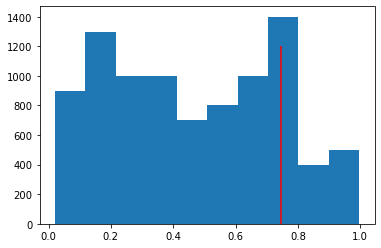

In [97]:
field = "ff"

print("{} value in ground truth map is {}".format(field,makevol(m.paramMap[field],m.mask>0)[idx_max[1],idx_max[2]]))
plt.hist(m.paramMap[field])
plt.vlines(x=makevol(m.paramMap[field],m.mask>0)[idx_max[1],idx_max[2]],ymin=0,ymax=1200,color="red")

In [ ]:
np.argmax()

wT1 value in ground truth map is 1650.5586562788112


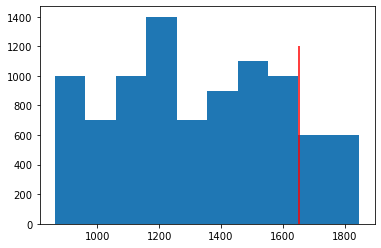

In [98]:
field = "wT1"

print("{} value in ground truth map is {}".format(field,makevol(m.paramMap[field],m.mask>0)[idx_max[1],idx_max[2]]))
plt.hist(m.paramMap[field])
plt.vlines(x=makevol(m.paramMap[field],m.mask>0)[idx_max[1],idx_max[2]],ymin=0,ymax=1200,color="red")

In [120]:
indices_max_error=np.unravel_index(np.argsort((error_all.flatten()))[::-1][:100000],error_all.shape)

In [121]:
mask_max = np.zeros(error_all.shape[1:])

In [134]:
indices_max_error_unique=np.unique(np.array(indices_max_error)[1:].T,axis=0)

In [125]:
mask_max[indices_max_error_unique]=1

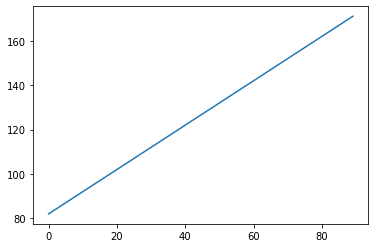

In [138]:
plt.plot(np.sort(np.unique(indices_max_error[1])))

In [140]:
len(np.unique(indices_max_error[1]))

90

In [141]:
len(np.unique(indices_max_error[2]))

100

In [143]:
(m.paramMap["wT1"]>0).sum()

9000

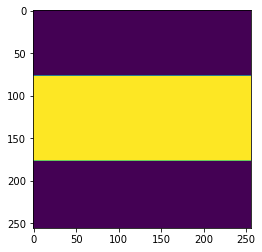

In [127]:
plt.imshow(mask_max)

In [126]:
mask_max.sum()

25600.0

attB1 value in ground truth map is 0.8691789695275325


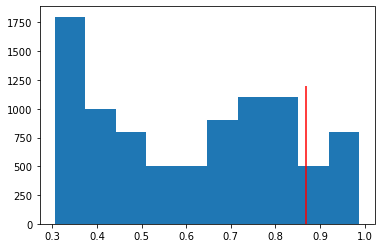

In [99]:
field = "attB1"

print("{} value in ground truth map is {}".format(field,makevol(m.paramMap[field],m.mask>0)[idx_max[1],idx_max[2]]))
plt.hist(m.paramMap[field])
plt.vlines(x=makevol(m.paramMap[field],m.mask>0)[idx_max[1],idx_max[2]],ymin=0,ymax=1200,color="red")

df value in ground truth map is 0.01400324176493649


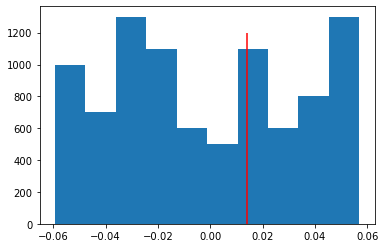

In [100]:
field = "df"

print("{} value in ground truth map is {}".format(field,makevol(m.paramMap[field],m.mask>0)[idx_max[1],idx_max[2]]))
plt.hist(m.paramMap[field])
plt.vlines(x=makevol(m.paramMap[field],m.mask>0)[idx_max[1],idx_max[2]],ymin=0,ymax=1200,color="red")

(array([1., 1., 0., 1., 0., 1., 1., 0., 1., 1.]),
 array([0. , 0.6, 1.2, 1.8, 2.4, 3. , 3.6, 4.2, 4.8, 5.4, 6. ]),
 <BarContainer object of 10 artists>)

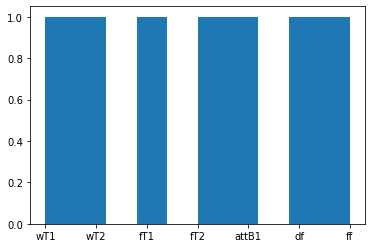

In [82]:
plt.hist(m.paramMap)

In [28]:
m.images_series[idx_max[0],idx_max[1],idx_max[2]]

(-0.017700108566527175+0.0057833566807044354j)

In [30]:
simulations[idx_max[0],idx_max[1],idx_max[2]]

(0.026679995408650112-0.007544962842699548j)

In [31]:
error_all[idx_max[0],idx_max[1],idx_max[2]]

0.04633829658247591

In [32]:
np.abs(m.images_series[idx_max[0],idx_max[1],idx_max[2]]-simulations[idx_max[0],idx_max[1],idx_max[2]])

0.046338296582475916

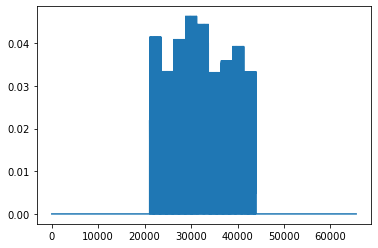

In [24]:
plt.plot(np.max(error_all.reshape(1400,-1),axis=0))

In [ ]:
plt.plot(np.max(error_all.reshape(1400,-1),axis=0))

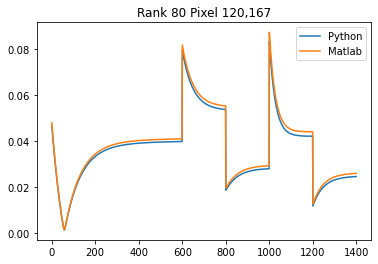

In [17]:
rank=80
error_all = np.abs(m.images_series-simulations)
idx_max = np.argsort((error_all.flatten()))[-rank]
idx_max=np.unravel_index(idx_max,error_all.shape)
plt.plot(np.abs(m.images_series[:,idx_max[1],idx_max[2]]),label="Python")
plt.plot(np.abs(simulations[:,idx_max[1],idx_max[2]]),label="Matlab")
plt.title("Rank {} Pixel {},{}".format(rank,idx_max[1],idx_max[2]))

plt.legend()

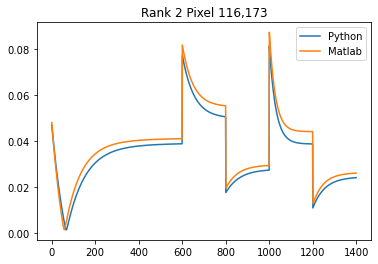

In [145]:
rank=2
error_all = np.abs(m.images_series-simulations)
idx_max = np.argsort((error_all.flatten()))[-rank]
idx_max=np.unravel_index(idx_max,error_all.shape)
plt.plot(np.abs(m.images_series[:,idx_max[1],idx_max[2]]),label="Python")
plt.plot(np.abs(simulations[:,idx_max[1],idx_max[2]]),label="Matlab")
plt.title("Rank {} Pixel {},{}".format(rank,idx_max[1],idx_max[2]))

plt.legend()

In [146]:
field = "ff"

print("{} value in ground truth map is {}".format(field,makevol(m.paramMap[field],m.mask>0)[idx_max[1],idx_max[2]]))
print("{} value in python map is {}".format(field,makevol(all_maps_adj[2][0][field],all_maps_adj[2][1]>0)[idx_max[1],idx_max[2]]))
print("{} value in matlab map is {}".format(field,makevol(map_rebuilt_Matlab.paramMap[field],map_rebuilt_Matlab.mask>0)[idx_max[1],idx_max[2]]))

ff value in ground truth map is 0.95
ff value in python map is 0.946693651239975
ff value in matlab map is 0.95


/home/cslioussarenko/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [147]:
field = "wT1"

print("{} value in ground truth map is {}".format(field,makevol(m.paramMap[field],m.mask>0)[idx_max[1],idx_max[2]]))
print("{} value in python map is {}".format(field,makevol(all_maps_adj[2][0][field],all_maps_adj[2][1]>0)[idx_max[1],idx_max[2]]))
print("{} value in matlab map is {}".format(field,makevol(map_rebuilt_Matlab.paramMap[field],map_rebuilt_Matlab.mask>0)[idx_max[1],idx_max[2]]))

wT1 value in ground truth map is 1834.0
wT1 value in python map is 1999.0
wT1 value in matlab map is 1650.0


In [136]:
makevol(all_maps_adj[2][0]["wT1"],all_maps_adj[2][1]>0)[idx_max[1],idx_max[2]]

/home/cslioussarenko/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


1999.0

In [137]:
makevol(map_rebuilt_Matlab.paramMap["wT1"],map_rebuilt_Matlab.mask>0)[idx_max[1],idx_max[2]]

/home/cslioussarenko/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


1750.0

In [127]:
idx_max

(800, 112, 167)

In [118]:
error_all_reshaped = error_all.reshape(1400,-1)
idx_sorted_on_path=np.argsort(error_all_reshaped,axis=0)

In [125]:
np.argsort(error_all_reshaped.flatten())

array([       0, 58913470, 58913469, ..., 52458409, 52458669, 52459951])

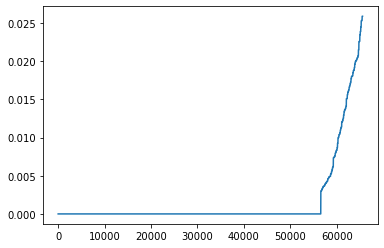

In [120]:
idx_sorted_along_sig = np.argmax(error_all_reshaped[idx_sorted_on_path[-2,:],range(error_all_reshaped.shape[1])])

In [116]:
idx_sorted_on_path[-2,:].shape

(65536,)

In [117]:
error_all.shape

(1400, 256, 256)